# Analysing Twitter Data on Insomnia

This is my third-year Computer Science project at the University of Manchester. 

This notebook contains the code which trains a selected transformer model. Specifically these models have been tested: BERT, RoBERTa, DistilBERT and BERTweet. The notebook contains code to read a dataset, split it into train/val/test sets, do some preprocessing like subjective tweet filtering. Hyperparameters of the model are provided in the **Define Constants, Hyperparameters, Objects and Configurations** section. Afterwards, the base model is fetched from HuggingFace, but after that fine-tuned with Pytorch. Training loop, dataloaders and evaluation code are provided in subsequent sections. On top of that, k-Cross-Validation is utilised to obtain more reliable results. Also, a section of **Do Inference on Tweets Dataset** allows to make predictions on unseen tweets which can be stored locally and be used for experiments in the **TweetExperiments** notebook. What is more, an ensemble of transformers with the Bagging method was built to compare results with a single model and k-Cross-Validation. 

The code was developed using the **Kaggle** platform, but it is adapted to be run on the **Google Colab** platform.

Essential things to have to run this notebook: 
1. Set the **BASE_PATH** which is the project directory to access the dataset.
2. Make sure you have json (or at least csv) file which consists of tweets on insomnia. If not, then you can firstly run **TweetCollector** notebook to collect tweets. You can update the names of files in the **Define Constants** section if preferred.

© 2023 Lukas Rimkus 

# Connect to the Google Drive

Firstly, connect to the Google Drive to be able to access files from there to read and store tweets.

If other platform is used to run the notebook code, then comment this out. 

In [1]:
from google.colab import drive, files

colab_path = '/content/drive'
drive.mount(colab_path)

# Install and Import Required Libraries for Tweets Topic Modelling

In [2]:
#@title Install Libraries
!pip install transformers
!pip install emoji

## Import Essential Libraries

In [3]:
import os
import sys
import re
import time
import datetime
import json
import string
import requests
import random
from collections import Counter

import emoji

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc

import torch
import transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, get_linear_schedule_with_warmup, TrainingArguments, Trainer
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, Sampler, RandomSampler, SequentialSampler, random_split, Dataset

from textblob import TextBlob, Word, Blobber

from tqdm.auto import tqdm

# Define Constants, Hyperparameters, Objects and Configurations

In [4]:
BASE_PATH = "/content/drive/MyDrive/Third Year Project"

# Hyperparameters
FOLDS = 5
epochs = 10
batch_size = 16
learning_rate = 3e-5
test_size = 0.1
subjectivity_threshold = 0.1
weight_decay = 1e-2
use_early_stopping = False
patience = 3
test_split_random_state = 10
init_seed_val = 10

json_file_name = "data.json"
annotated_tweets_file_name = "annotated_tweets.json"
labelled_topics_file_name = "labelled_topic_modelling_tweets.json"

json_file_path = f"{BASE_PATH}/{json_file_name}"
annotated_tweets_file_path = f"{BASE_PATH}/{annotated_tweets_file_name}"
labelled_topic_tweets_path = f"{BASE_PATH}/{labelled_topics_file_name}"

plt.rcParams["figure.figsize"] = (12, 6)

# Preprocessing and Data Preparation

## Methods for Reading Datasets 

In [5]:
def read_json_dataset(json_path: str) -> tuple:
    """
    This method checks if there exists a json file at the given path. If it exists, 
    then it is read and consequently returned.
    """
    file_exists = os.path.exists(json_path)
    if not file_exists:
        print(f"There is no file at: {json_path}")
        return False, None

    # Read the dataset
    tweets_df = pd.read_json(json_path, orient="records")

    return True, tweets_df


def open_json_file(file_path: str) -> pd.DataFrame:
    """
    This method calls the method 'read_json_dataset' and is an abstraction of that 
    method to read and return json files of tweets. 
    """
    success, tweets_df = read_json_dataset(file_path)
    if not success:
        return
    
    return tweets_df

In [6]:
tweets_df = open_json_file(annotated_tweets_file_path)
tweets_df.head()

,Publish Date,Location,Tweet,Sentiment
0,1673529293000,WA,I feel. Even melatonin won’t help 😩,0
1,1672724214000,,Can't sleep so ask me stuff url,1
2,1674133015000,yaaay areaaa,These sleepless nights are catching up,1
3,1673892049000,Her DM,I read that chat 4 times 😍💕\nSleeping pill\n\n...,2
4,1675290996000,,"“ It's a pleasure, it will mean that I will h...",2


In [7]:
tweets_df['Sentiment'].value_counts()

1    353
0    351
2    304
Name: Sentiment, dtype: int64

## Subjectivity Analysis Filtering

In [8]:
def filter_subjective_tweets(tweets_df, threshold):
    """
    This method removes tweets which are considered to not be subjective. It is done 
    using TextBlob subjectivity property which gives values [0, 1] where 1 is highly 
    subjective. Through experimentation, I chose to use a threshold of 0.1 for tweets  
    to be preserved in the datframe.
    """
    number_of_original_tweets = len(tweets_df)

    subjectivities = np.zeros(number_of_original_tweets)

    for i, tweet in enumerate(tweets_df["Tweet"]):
        tweet_blob = TextBlob(tweet)
        subjectivity = tweet_blob.subjectivity
        
        subjectivities[i] = subjectivity

    tweets_df["Subjectivity"] = subjectivities

    subjective_tweets_df = tweets_df[tweets_df["Subjectivity"] > threshold].copy()
    subjective_tweets_df.drop(columns=["Subjectivity"], inplace=True)
    subjective_tweets_df = subjective_tweets_df.reset_index()

    return subjective_tweets_df

Uncomment the code below to train models only on subjective tweets. 

In [9]:
# tweets_df = filter_subjective_tweets(tweets_df, subjectivity_threshold)

## Drop Unnecessary Columns for Training

In [10]:
tweets_df.drop(columns=["Publish Date", "Location"], inplace=True)
tweets_df.head()

,Tweet,Sentiment
0,I feel. Even melatonin won’t help 😩,0
1,Can't sleep so ask me stuff url,1
2,These sleepless nights are catching up,1
3,I read that chat 4 times 😍💕\nSleeping pill\n\n...,2
4,"“ It's a pleasure, it will mean that I will h...",2


## Obtain and Split the Data

In [11]:
number_of_tweets = len(tweets_df)

tweets = tweets_df["Tweet"].values
labels = tweets_df["Sentiment"].values

## Training and Testing Split

In [12]:
tweets_df_train, tweets_df_test = train_test_split(tweets_df, test_size=test_size, random_state=test_split_random_state, stratify=tweets_df["Sentiment"])

training_tweets = tweets_df_train["Tweet"].values
training_labels = tweets_df_train["Sentiment"].values

In [13]:
print(f'Number of training (and validation) tweets: {len(tweets_df_train)} \nTraining Value counts:\n{tweets_df_train["Sentiment"].value_counts()}\n')
print(f'Number of testing tweets: {len(tweets_df_test)} \nTesting Value counts:\n{tweets_df_test["Sentiment"].value_counts()}\n')

Number of training (and validation) tweets: 907 
Training Value counts:
1    318
0    316
2    273
Name: Sentiment, dtype: int64

Number of testing tweets: 101 
Testing Value counts:
1    35
0    35
2    31
Name: Sentiment, dtype: int64



# Transformer Model Definition 

## Get the Device
Check if there is GPU Available preferably, as it would take a plethora of time to train on a CPU. 

In [14]:
def get_device() -> torch.device:
    """
    This method checks if GPU is available, if it is, then an object representing it is returned.
    Otherwise, CPU is utilised.  
    """
    if torch.cuda.is_available():    
        # Tell PyTorch to use the GPU.    
        device = torch.device("cuda")

        print(f'There are {torch.cuda.device_count()} GPU(s) available.')

        print(f'I will use the GPU: {torch.cuda.get_device_name(0)}')

    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")

    return device

In [15]:
device = get_device()

There are 1 GPU(s) available.
I will use the GPU: Tesla P100-PCIE-16GB


## Choose the Model

In [16]:
# model_name = "bert-base-cased"
# model_name = "roberta-base"
model_name = "vinai/bertweet-base"
# model_name = "distilbert-base-cased"

models_to_test_names = [model_name]

## Find out the Max Length and Plot the Lengths of Tweets

If the number of tokens is less, then the tokenisation takes less time, thus it is more efficient.

In [17]:
def plot_tweet_lengths(tweet_lengths: np.ndarray, max_len: int) -> None:
    """
    This method plots the number of tokens per each tweet using a matplotlib plot. 
    """
    print(f"Max length of tokens in tweets: {max_len}")
    counts = Counter(tweet_lengths)

    fig = plt.figure(figsize = (10, 7)) 
    plt.bar(list(counts.keys()), list(counts.values()))

    plt.xlabel("Tweet Tokens Number") 
    plt.ylabel("No. of Tweets of that Length ") 
    plt.title("Number of Tokens per Tweet") 

    plt.show()
    

def get_max_tweet_length(tweets: np.ndarray, tokenizer: AutoTokenizer) -> int:
    """
    This method finds the longest number of tokens across tweets. All tweets number of
    tokens are plotted in a diagram.   
    """
    max_len = 0

    tweet_lengths = np.zeros(len(tweets)) 

    for i, sent in enumerate(tweets):
        # Tokenize the text and add special tokens like [CLS] and [SEP]
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        tweet_length = len(input_ids)
        
        # Update the maximum sentence length
        max_len = max(max_len, tweet_length)

        tweet_lengths[i] = tweet_length
    
    plot_tweet_lengths(tweet_lengths, max_len)
    
    return max_len


## Tokenise the Whole Dataset of Tweets 

In [18]:
def encode_tweets(tweets: np.ndarray, labels: np.ndarray, max_len: int, tokenizer: AutoTokenizer) -> tuple:
    """
    This method tokenises each tweet with the given model tokenizer. It uses padding 
    and truncation if the tweets are too short or too long respectively. 
    Tokenised tweet representations are returned. 
    """

    input_ids = []
    attention_masks = []

    for tweet in tweets:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,           # Pad & truncate all sentences.
                            padding='max_length',
                            return_attention_mask = True,   # Construct attn. masks.
                            truncation=True,
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels


In [19]:
def create_tweets_dataloader(tweets: np.ndarray, labels: np.ndarray, max_len: int, sampler: Sampler, batch_size: int, tokenizer: AutoTokenizer) -> DataLoader:
    """
    This method created a dataloader object given parameters of labels, max number of tokens, 
    type of the sampler, batch size and model's tokenizer.  
    """
    input_ids, attention_masks, labels = encode_tweets(tweets, labels, max_len, tokenizer)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    
    dataloader = DataLoader(
            dataset, 
            sampler = sampler(dataset), 
            batch_size = batch_size 
    )
    
    return dataloader


## Evaluation Metrics

In [20]:
def plot_losses(training_stats: dict) -> None:
    """
    This method plots a graph showing how the losses of both the training and validation datasets
    changes over epochs. A separate line is drawn for each training and validation statistics.
    The data is taken from the training stats dictionary.
    """
    df_stats = pd.DataFrame(data=training_stats)

    train_dataset_loss, test_dataset_loss = df_stats['Training Loss'], df_stats['Valid. Loss']
    
    epochs_number = len(training_stats)
    
    # Plot the learning curve.
    plt.plot(np.arange(1, epochs_number+1), train_dataset_loss, 'b-o', label="Training")
    plt.plot(np.arange(1, epochs_number+1), test_dataset_loss, 'g-o', label="Validation")
    
    # Plot the labels with respective loss for each data point
    for i, (train_loss, test_loss) in enumerate(zip(train_dataset_loss, test_dataset_loss)):
        train_label = f"{train_loss:.3f}"

        plt.annotate(train_label, 
             (i+1, train_loss), 
             textcoords="offset points", 
             xytext=(0,10), 
             ha='center') 
        
        test_label = f"{test_loss:.3f}"
        
        plt.annotate(test_label, 
             (i+1, test_loss),
             textcoords="offset points", 
             xytext=(0,10), 
             ha='center') 

    
    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(range(1, epochs_number+1))
    plt.grid()
    
    plt.show()


def plot_accuracies(training_stats: dict) -> None:
    """
    This method plots a graph showing how the accuracies of both the training and validation datasets
    changes over epochs. A separate line is drawn for each training and validation statistics.
    The data is taken from the training stats dictionary.
    """
    df_stats = pd.DataFrame(data=training_stats)

    train_dataset_accuracy, test_dataset_accuracy = df_stats['Training Accur.'], df_stats['Valid. Accur.']
    
    epochs_number = len(training_stats)
    
    # Plot the learning curve.
    plt.plot(np.arange(1, epochs_number+1), train_dataset_accuracy, 'b-o', label="Training")
    plt.plot(np.arange(1, epochs_number+1), test_dataset_accuracy, 'g-o', label="Validation")
    
    # Plot the labels with respective accuracy for each data point
    for i, (train_accuracy, test_accuracy) in enumerate(zip(train_dataset_accuracy, test_dataset_accuracy)):
        train_label = f"{train_accuracy:.3f}"

        plt.annotate(train_label, 
             (i+1, train_accuracy), 
             textcoords="offset points",
             xytext=(0,10), # distance from text to points (x,y)
             ha='center') 
        
        test_label = f"{test_accuracy:.3f}"
        
        plt.annotate(test_label, 
             (i+1, test_accuracy),
             textcoords="offset points",
             xytext=(0,10),
             ha='center') 

    # Label the plot.
    plt.title("Training & Validation Accuracies")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.xticks(range(1, epochs_number+1))
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    plt.grid()
    
    plt.show()


In [21]:
def format_time(elapsed):
    """
    Takes a time in seconds and returns a string hh:mm:ss
    """
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def print_metrics(true_labels: np.ndarray, predicted_labels: np.ndarray) -> None:
    """
    This method prints these model evaluation metrics: Accuracy, Precision, Recall and F1 Score. 
    """
    accuracy, precision, recall, f1_value = return_metrics(true_labels, predicted_labels) 
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_value:.4f}")


def return_metrics(true_labels: np.ndarray, predicted_labels: np.ndarray) -> tuple:
    """
    This method returns these model evaluation metrics: Accuracy, Precision, Recall and F1 Score. 
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1_value = f1_score(true_labels, predicted_labels, average='macro')
    
    return accuracy, precision, recall, f1_value

    
def display_confusion_matrix(true_labels: np.ndarray, predicted_labels: np.ndarray) -> None:
    """
    This method takes true and predicted labels and plots a confusion matrix on that.
    """
    display_labels = ["Negative", "Neutral", "Positive"]

    cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()


def display_classification_report(true_labels: np.ndarray, predicted_labels: np.ndarray) -> None:
    """
    This method prints the classification report.
    """
    print(classification_report(y_true=true_labels, y_pred=predicted_labels, labels=[0, 1, 2]))
    

def display_model_performance_metrics(true_labels: np.ndarray, predicted_labels: np.ndarray) -> None:
    """
    This method prints various metrics for doing model final evaluation in terms of true and predicted labels.
    """
    print('Model Performance metrics:\n')
    print_metrics(true_labels=true_labels, predicted_labels=predicted_labels)

    print('\n\nModel Classification report:')
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels)

    print('\n\nPrediction Confusion Matrix:')
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels)

## Early Stopping Class Definition

Inspired by this [repository](https://github.com/Bjarten/early-stopping-pytorch).

In [22]:
class EarlyStopping:
    """
    This class defines the workflow of checking whether and when the model training should 
    terminate due to prevalent overfitting for the validation loss.  
    """

    def __init__(self, patience: int=3, path: str="./early_stopping/best_model", delta: float=0, tokenizer: AutoTokenizer=None, true_labels: np.ndarray=None) -> None:
        """
        Initialise and set variable values in the constructor.  
        """
        self.patience = patience
        self.path = path
        self.min_val_loss = None
        self.counter = 0
        self.delta = delta
        self.tokenizer = tokenizer
        self.true_labels = true_labels
        self.early_stop = False
        
    def __call__(self, val_loss: float, predictions: np.ndarray, model: AutoModelForSequenceClassification) -> None:
        """
        This checks if the validation loss gets better or worse. If it does not keep
        improving, then terminate the training process. Keep setting the best model 
        found so far. 
        """
        # At first, save the model after the first epoch as the best one
        if self.min_val_loss is None:
            self.min_val_loss = val_loss
            save_model(self.path, model, self.tokenizer)
            self.predictions = predictions
        
        # If the loss keep increasing, then check for how many times it happened. 
        # If it reaches the number of 'patience', then set the termination flag to True
        elif val_loss > self.min_val_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("\nTerminate Early!\n")
                self.early_stop = True

        # If the loss is smaller than previous one, save this model as the best one so far
        else:
            self.min_val_loss = val_loss
            save_model(self.path, model, self.tokenizer)
            self.predictions = predictions
            self.counter = 0
    
    def terminate_early(self) -> bool:
        """
        Check if the model training reaches a stage where it can be terminates when 
        the validation loss does not get better anymore. 
        """
        return self.early_stop
    
    def return_best_model(self) -> AutoModelForSequenceClassification:
        """
        Return the best found model during training so far. 
        """
        model = AutoModelForSequenceClassification.from_pretrained(self.path)
        return model

## Training Loop and Cross-Validation

Training and evaluation code inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/.

**Training:**
- Unpack data inputs and class labels.
- Load data onto the GPU for better acceleration compared to CPU.
- Clear out the gradients calculated in the last pass. 
    - In pytorch the gradients accumulate by default (e.g. useful for RNNs) unless you explicitly clear them out which is needed here.
- Forward pass (feed input data through the neural network).
- Backpropagation pass.
- Update parameters with optimizer.step().
- Track variables for performance monitoring progress.

**Evalution:**
- Unpack data inputs and class labels.
- Load data onto the GPU for better acceleration compared to CPU.
- Forward pass (feed input data through the neural network).
- Compute loss and accuracy on the validation data and track variables for performance monitoring progress.

**k Cross-Validation:**
- Repeat the above steps given number of times.
- Take stratified samples for both training and validation sets for training one model. 
- During the whole process, whole data will be used for training k-1 times, whereas for evaluation - 1 time. 


In [23]:
def train(total_steps: int, epochs: int, model: AutoModelForSequenceClassification, train_dataloader: DataLoader, device: torch.device, 
          optimizer: AdamW, scheduler: transformers.SchedulerType, validation_dataloader: DataLoader, early_stopping: EarlyStopping=None) -> tuple:
    """
    This method does the whole training and evaluation of the model given number of epochs,
    unless early stopping is used to terminate earlier. 
    """
    progress_bar = tqdm(range(total_steps))
    
    # Store a number of quantities such as training and validation loss, validation accuracy, and timings
    training_stats = []

    # Measure the total training time for the whole run
    start = time.time()

    for epoch_i in range(epochs):
        model, epoch_stats = train_epoch(model, train_dataloader, device, epoch_i, epochs, optimizer, scheduler, progress_bar, validation_dataloader)
        training_stats.append(epoch_stats)
        
        if use_early_stopping:
            early_stopping(epoch_stats["Valid. Loss"], epoch_stats["Evaluation Predictions"], model)
            
            if early_stopping.terminate_early():
                # Performance statistics are only displayed after the last epoch, thus it has to
                # be called here explicitly. Predictios are set there for the best model found
                display_model_performance_metrics(early_stopping.true_labels, early_stopping.predictions)
                model = early_stopping.return_best_model()
                break
        
    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-start)))

    return model, training_stats


def train_epoch(model: AutoModelForSequenceClassification, train_dataloader: DataLoader, device: torch.device, 
                epoch_i: int, epochs: int, optimizer: AdamW, scheduler: transformers.SchedulerType, progress_bar: tqdm, 
                validation_dataloader: DataLoader) -> tuple:
    """
    This method goes through one epoch of the model training. Training is done and evaluation is done 
    to calculate the training and evaluation loss and accuracy. Statistics of this epoch training 
    is returned. 
    """
    print(f'\n======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    # Measure how long the training epoch takes
    t0 = time.time()

    # Reset the total loss for this epoch
    total_train_loss = 0
    total_train_accuracy = 0
    total_correct_predictions = 0
    total_labels = 0
    
    # Put the model into training mode. The call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    for step, batch in enumerate(train_dataloader):
        # Those parameters are changed by passing them by parameters and returning them to update the values 
        model, total_train_loss, total_train_accuracy, total_correct_predictions, total_labels = train_batch(batch, model, device, optimizer, 
                                                                                                             scheduler, progress_bar, total_train_loss, 
                                                                                                             total_train_accuracy, total_correct_predictions, 
                                                                                                             total_labels)
    
    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    train_accuracy = float(total_correct_predictions / total_labels)

    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)
    print("")
    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time:}")
    print(f"  Training Accuracy: {train_accuracy:.2f}")

    # After the completion of each training epoch, measure the performance on the validation set
    print("\nRunning Validation...")
    last_epoch = (epoch_i + 1) == epochs
    total_eval_loss, t0, validation_accuracy, predicted_labels, probabilities = evaluate_results(validation_dataloader, model, device, last_epoch)

    # Report the final accuracy for this validation run
    print(f"  Validation Accuracy: {validation_accuracy:.2f}")

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)

    print(f"Validation Loss: {avg_val_loss:.2f}")
    print(f"Validation took: {validation_time:}")

    # Record all statistics from this epoch
    epoch_stats = {
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        "Training Accur.": train_accuracy,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': validation_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time,
        'Evaluation Predictions': predicted_labels,
        'Probabilities': probabilities
    }
    
    return model, epoch_stats


def train_batch(batch: torch.Tensor, model: AutoModelForSequenceClassification, device, optimizer, scheduler: transformers.SchedulerType, 
                progress_bar: tqdm, total_train_loss: float, total_train_accuracy: float, total_correct_predictions: int, total_labels: int) -> tuple:
    """
    This method trains one batch of tweets. Model generates an output, loss is calculated, 
    a backwards pass is done, gradient is clipped, optimizer and scheduler are updated, gradient is cleaned
    and finally training accuracy is found.  
    """
    # Unpack this training batch from our dataloader. 
    # As we unpack the batch, we'll also copy each tensor to the device using the 
    # `to` method. Batch contains three pytorch tensors:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Perform a forward pass (evaluate the model on this training batch).
    # In PyTorch, calling `model` will in turn call the model's `forward` 
    # function and pass down the arguments. The `forward` function is 
    # documented here: 
    # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
    # The results are returned in a results object, documented here:
    # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
    # Specifically, get the loss (because we provided labels) and the
    # "logits" -- the model outputs prior to activation.

    output = model(b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels,
                    return_dict=True) 
    
    loss = output.loss
    logits = output.logits

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this automatically because
    # accumulating the gradients is "convenient while training RNNs". 
    # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
    optimizer.zero_grad()

    # Calculate the training accuracy
    # This finds the the indices of the max values which correspond to classes [0, 1, 2]
    _, preds = torch.max(logits, dim=1)
    total_correct_predictions += torch.sum(preds == b_labels)
    total_labels += len(b_labels)

    progress_bar.update(1)
    
    return model, total_train_loss, total_train_accuracy, total_correct_predictions, total_labels

In [24]:
def evaluate_results(dataloader: DataLoader, model: AutoModelForSequenceClassification, device: torch.device, last_epoch: bool) -> tuple:
    """
    This method takes a model after training some number of epochs and uses it to evaluate
    its performance on the validation set. 
    """
    t0 = time.time()

    # Put the model in evaluation mode because the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_loss = 0
    total_correct_predictions = 0
    total_labels = 0

    true_labels, predicted_labels, probabilities = list(), list(), list()

    # Evaluate data for one epoch
    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backpropogation (training).
        with torch.no_grad():     
            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            output = model(b_input_ids, 
                           attention_mask=b_input_mask,
                           labels=b_labels)

        # Get the loss and "logits" output by the model. The "logits" are the output values prior to applying an 
        # activation function like the softmax.
        loss = output.loss
        logits = output.logits
        
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        probs = torch.nn.functional.softmax(logits, dim=1)
        
        # Move logits, probs and labels to CPU if we are using GPU
        logits = logits.detach().cpu().numpy()
        probs = probs.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
    
        # find how many have been predicted correctly
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        total_correct_predictions += np.sum(pred_flat == labels_flat)
        total_labels += len(labels_flat)
        
        true_labels.extend(labels_flat)
        predicted_labels.extend(pred_flat)
        probabilities.extend(probs)
    
    # Display statistics of the whole epoch using graphs after reaching the last epoch
    if last_epoch:
        display_model_performance_metrics(true_labels, predicted_labels)
    
    eval_accuracy = total_correct_predictions / total_labels
    return total_eval_loss, t0, eval_accuracy, predicted_labels, probabilities

In [25]:
def k_fold(epochs: int, tokenizer: AutoTokenizer, max_len: int, model_name: str) -> np.ndarray:
    """
    This method creates k-Cross-Validation of the training set which is split in a 
    stratified way so that there are not "unlucky splits" where some class dominates. 
    The results of each iteration are reported, displayed and averaged at the end.  
    """
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

    # store performance data for each model
    models_performance = list()

    seeds = list(range(init_seed_val, init_seed_val + FOLDS + 1))

    for i, (train_index, test_index) in enumerate(skf.split(training_tweets, training_labels)):
        # Take stratified training and validation dataset 
        tweet_train_fold = np.take(training_tweets, train_index, axis=0)
        labels_train_fold = np.take(training_labels, train_index)

        tweet_val_fold = np.take(training_tweets, test_index, axis=0)
        labels_val_fold = np.take(training_labels, test_index)

        # Set the random seed
        seed_val = seeds[i]
        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # Define the model
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, 
            num_labels = 3, 
            output_attentions = False, 
            output_hidden_states = False
        )
        
        model = model.to(device)

        # Create dataloaders for datasets
        train_dataloader = create_tweets_dataloader(tweet_train_fold, labels_train_fold, max_len, RandomSampler, batch_size, tokenizer)
        validation_dataloader = create_tweets_dataloader(tweet_val_fold, labels_val_fold, max_len, SequentialSampler, batch_size, tokenizer)
        
        total_steps = len(train_dataloader) * epochs
        
        optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=weight_decay)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
        
        early_stopping = EarlyStopping(patience=patience, tokenizer=tokenizer, true_labels=labels_val_fold)

        # Train the model and collect the training data
        model, training_stats_for_model = train(total_steps, epochs, model, train_dataloader, device, optimizer, scheduler, validation_dataloader, early_stopping)
        
        # Plot the training data about the loss and accuracy
        plot_losses(training_stats_for_model)
        plot_accuracies(training_stats_for_model)
        
        # Save the model which will be used for the testing step later on
        # Models are saved to not consume too much memory
        output_path = f"./temp_models/{model_name.replace('/', '-')}_model_{i+1}"
        save_model(output_path, model, tokenizer)
        models_performance.append(training_stats_for_model)
    
    return models_performance

In [26]:
def test_different_transformer_models(models_to_test_names: np.ndarray) -> tuple:
    """
    This method does kfold-Cross-Validation for the number of given different models
    (like BERT, BERTweet, etc.) which can be compared with each other as they use the same
    hyperparameters.
    """
    all_models_performance_metrics = list()
    models_tokenisers = list()
    models_max_lens = list()
    
    for transformer_model_name in models_to_test_names:
        print(f"============ Transformer {transformer_model_name} is now tested ============")
        
        # Define a tokeniser for this model architecture
        tokenizer = AutoTokenizer.from_pretrained(transformer_model_name)
        max_len = get_max_tweet_length(tweets, tokenizer)
        
        # Perform training
        models_performance = k_fold(epochs, tokenizer, max_len, transformer_model_name)

        all_models_performance_metrics.append(models_performance)
        models_tokenisers.append(tokenizer)
        models_max_lens.append(max_len)
        
        torch.cuda.empty_cache() 
        
        print(f"============ Transformer {transformer_model_name} was successfully tested ============\n\n")
    
    return all_models_performance_metrics, models_tokenisers, models_max_lens


In [27]:
def save_model(output_path: str, model: AutoModelForSequenceClassification, tokenizer: AutoTokenizer) -> None:
    """
    This method is used to save the models in some directory which can be loaded later  
    on for doing other tasks.
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Take care of distributed/parallel training
    model_to_save = model.module if hasattr(model, 'module') else model  
    model_to_save.save_pretrained(output_path)
    tokenizer.save_pretrained(output_path)

============ Transformer vinai/bertweet-base is now tested ============


Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Max length of tokens in tweets: 117


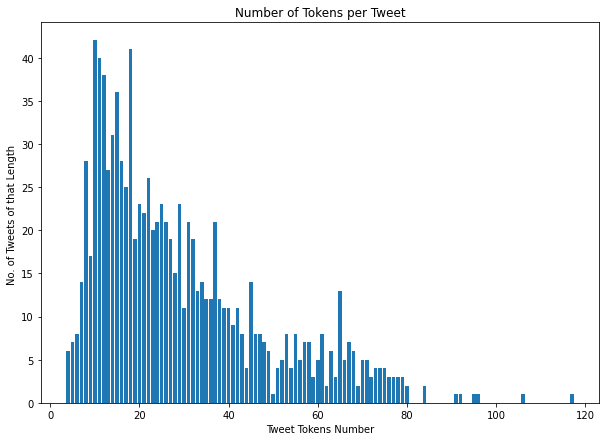

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.03
  Training epoch took: 0:00:10
  Training Accuracy: 0.47

Running Validation...
  Validation Accuracy: 0.53
Validation Loss: 1.01
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.81
  Training epoch took: 0:00:09
  Training Accuracy: 0.67

Running Validation...
  Validation Accuracy: 0.68
Validation Loss: 0.78
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.49
  Training epoch took: 0:00:09
  Training Accuracy: 0.83

Running Validation...
  Validation Accuracy: 0.68
Validation Loss: 0.86
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.33
  Training epoch took: 0:00:09
  Training Accuracy: 0.90

Running Validation...
  Validation Accuracy: 0.71
Validation Loss: 0.79
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.17


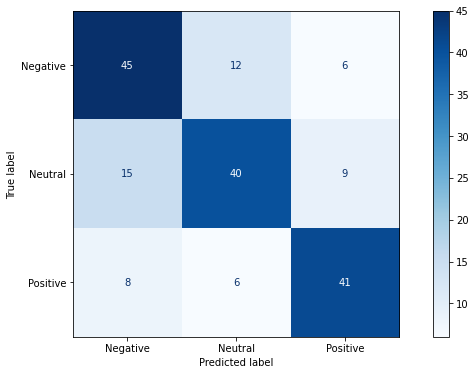

  Validation Accuracy: 0.69
Validation Loss: 1.35
Validation took: 0:00:01

Training complete!
Total training took 0:01:39 (h:mm:ss)


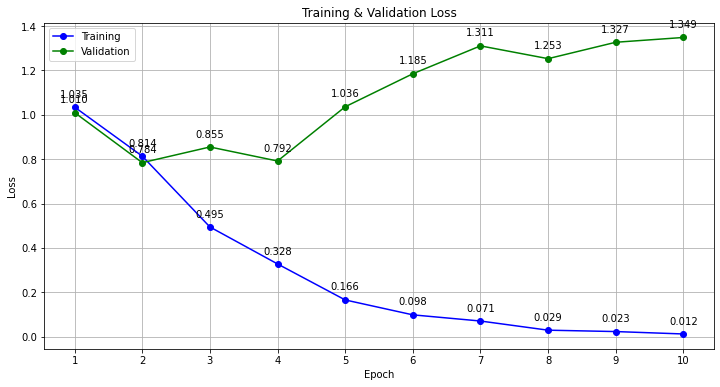

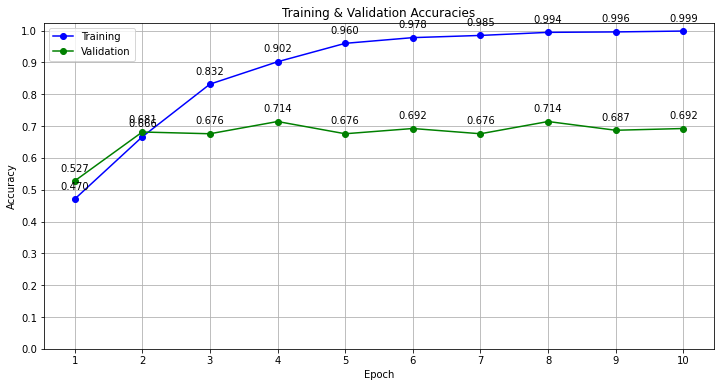

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.06
  Training epoch took: 0:00:09
  Training Accuracy: 0.41

Running Validation...
  Validation Accuracy: 0.63
Validation Loss: 0.92
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.77
  Training epoch took: 0:00:09
  Training Accuracy: 0.70

Running Validation...
  Validation Accuracy: 0.71
Validation Loss: 0.76
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.50
  Training epoch took: 0:00:09
  Training Accuracy: 0.83

Running Validation...
  Validation Accuracy: 0.71
Validation Loss: 0.73
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.35
  Training epoch took: 0:00:09
  Training Accuracy: 0.89

Running Validation...
  Validation Accuracy: 0.70
Validation Loss: 0.78
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.22


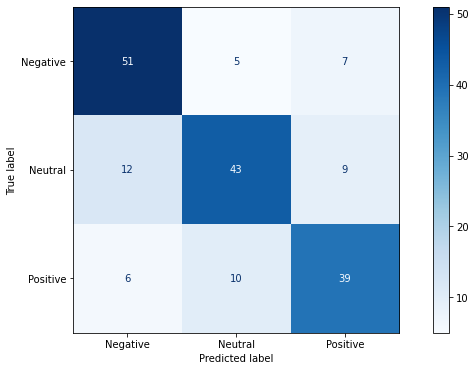

  Validation Accuracy: 0.73
Validation Loss: 1.22
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


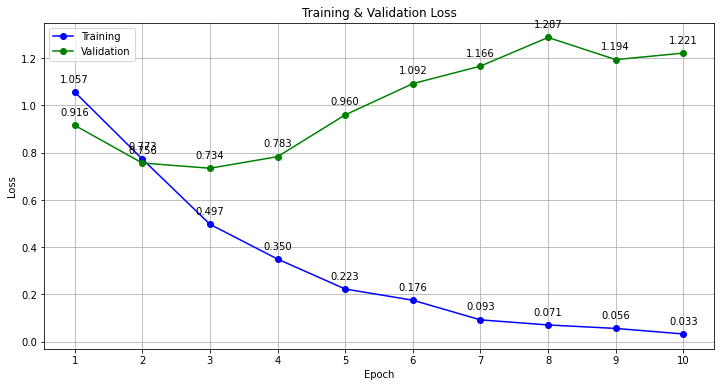

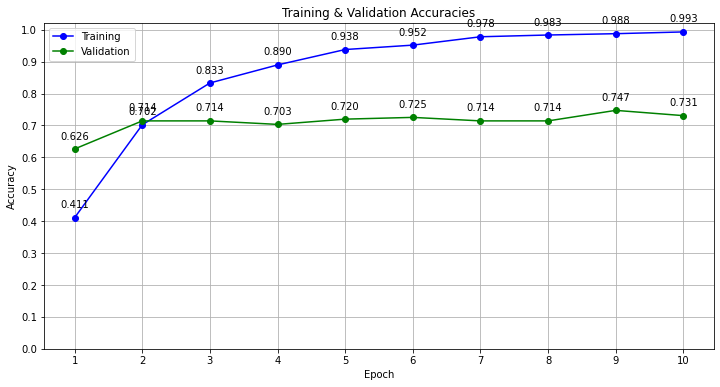

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.04
  Training epoch took: 0:00:09
  Training Accuracy: 0.48

Running Validation...
  Validation Accuracy: 0.61
Validation Loss: 0.87
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.80
  Training epoch took: 0:00:09
  Training Accuracy: 0.68

Running Validation...
  Validation Accuracy: 0.73
Validation Loss: 0.65
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.50
  Training epoch took: 0:00:09
  Training Accuracy: 0.83

Running Validation...
  Validation Accuracy: 0.66
Validation Loss: 0.83
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.35
  Training epoch took: 0:00:09
  Training Accuracy: 0.89

Running Validation...
  Validation Accuracy: 0.72
Validation Loss: 0.67
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.23


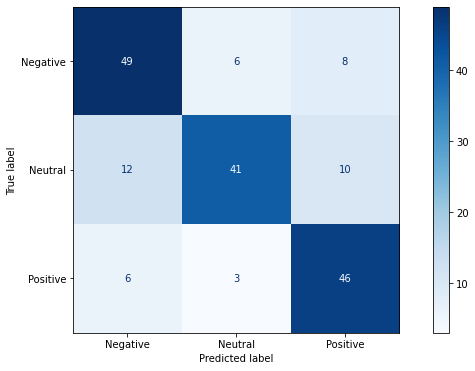

  Validation Accuracy: 0.75
Validation Loss: 1.00
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


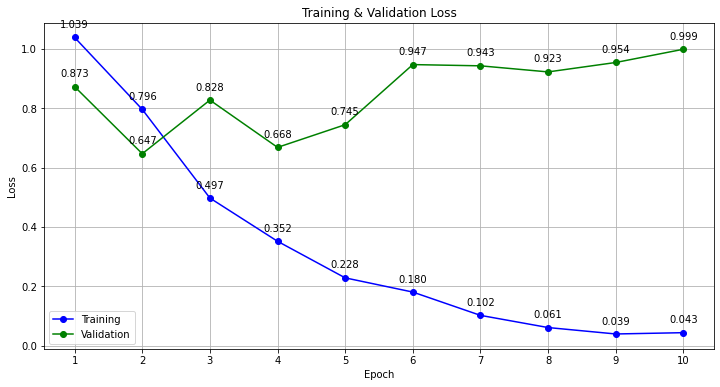

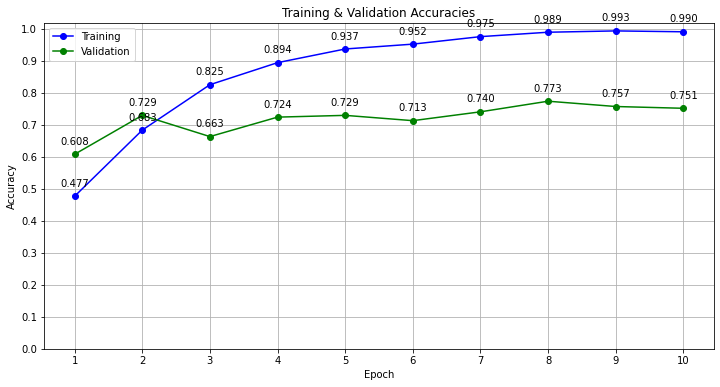

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.04
  Training epoch took: 0:00:09
  Training Accuracy: 0.44

Running Validation...
  Validation Accuracy: 0.56
Validation Loss: 0.94
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.80
  Training epoch took: 0:00:09
  Training Accuracy: 0.68

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 0.80
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.50
  Training epoch took: 0:00:09
  Training Accuracy: 0.84

Running Validation...
  Validation Accuracy: 0.71
Validation Loss: 0.70
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.33
  Training epoch took: 0:00:09
  Training Accuracy: 0.90

Running Validation...
  Validation Accuracy: 0.70
Validation Loss: 0.81
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.20


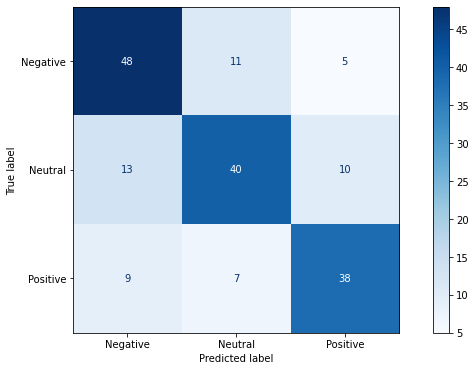

  Validation Accuracy: 0.70
Validation Loss: 1.23
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


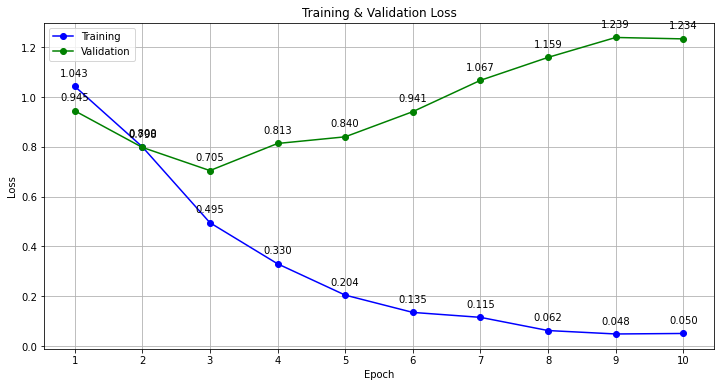

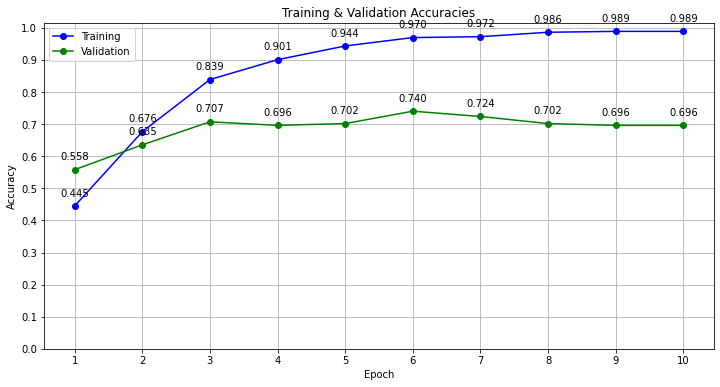

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.04
  Training epoch took: 0:00:09
  Training Accuracy: 0.46

Running Validation...
  Validation Accuracy: 0.61
Validation Loss: 0.94
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.78
  Training epoch took: 0:00:09
  Training Accuracy: 0.70

Running Validation...
  Validation Accuracy: 0.67
Validation Loss: 0.76
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.55
  Training epoch took: 0:00:09
  Training Accuracy: 0.81

Running Validation...
  Validation Accuracy: 0.74
Validation Loss: 0.69
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.34
  Training epoch took: 0:00:09
  Training Accuracy: 0.90

Running Validation...
  Validation Accuracy: 0.74
Validation Loss: 0.68
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.20


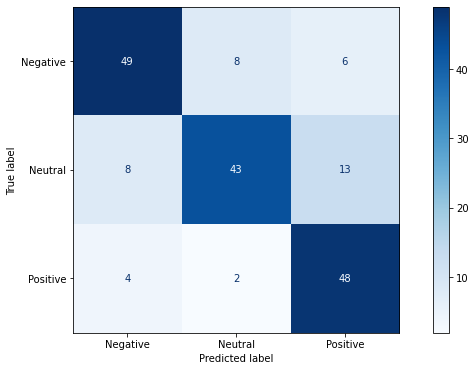

  Validation Accuracy: 0.77
Validation Loss: 1.10
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


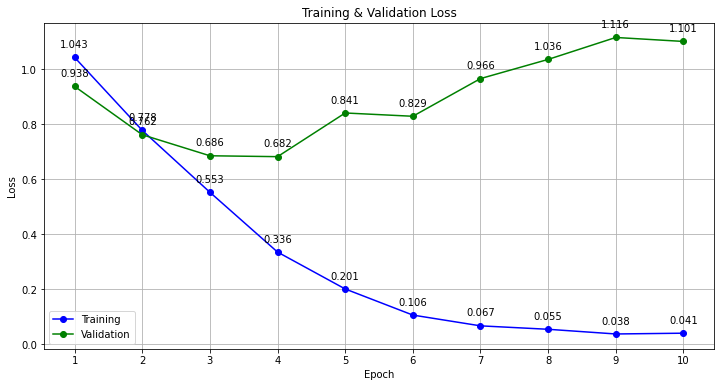

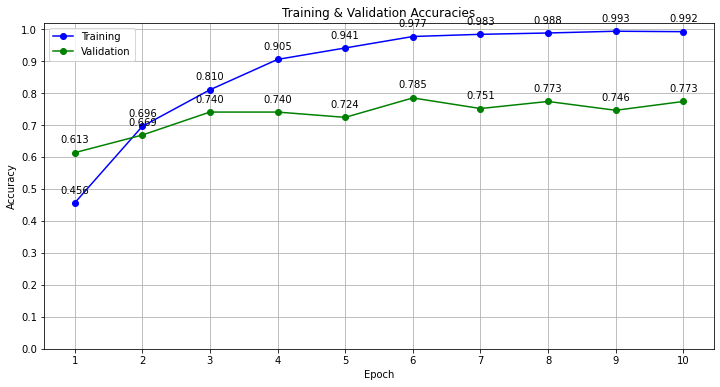

============ Transformer vinai/bertweet-base was successfully tested ============




In [28]:
all_models_performance_metrics, models_tokenisers, models_max_lens = test_different_transformer_models(models_to_test_names)

In [29]:
def display_mean_results_for_tested_models(models_to_test_names: np.ndarray, all_models_performance_metrics: np.ndarray) -> None:
    """
    Display mean results of k-Cross-Validation for each specified model architecture. 
    """
    for i, transformer_model_name in enumerate(models_to_test_names):
        print(f"============ Transformer {transformer_model_name} training is now evaluated ============")
        display_mean_results(all_models_performance_metrics[i])

        print("\n\n")


def display_mean_results(models_performance: np.ndarray) -> None:
    """
    This method displays averaged results for the k-Cross-Validation for some model 
    architecture with specified hyperparameters. 
    """
    final_epoch_results = [results[-1] for results in models_performance]
    
    training_accuracies = np.array([results["Training Accur."] for results in final_epoch_results])
    validation_accuracies = np.array([results["Valid. Accur."] for results in final_epoch_results])
    
    training_losses = np.array([results["Training Loss"] for results in final_epoch_results])
    validation_losses = np.array([results["Valid. Loss"] for results in final_epoch_results])

    print(f"Training Accuracy Mean: {training_accuracies.mean():.4f}, Std: {training_accuracies.std():.4f}")
    print(f"Training Loss Mean: {training_losses.mean():.4f}, Std: {training_losses.std()}")
    print(f"Testing Accuracy Mean: {validation_accuracies.mean():.4f}, Std: {validation_accuracies.std():.4f}")
    print(f"Testing Loss Mean: {validation_losses.mean():.4f}, Std: {validation_losses.std():.4f}")


In [30]:
display_mean_results_for_tested_models(models_to_test_names, all_models_performance_metrics)

============ Transformer vinai/bertweet-base training is now evaluated ============
Training Accuracy Mean: 0.9926, Std: 0.0033
Training Loss Mean: 0.0359, Std: 0.01311314403448886
Testing Accuracy Mean: 0.7288, Std: 0.0313
Testing Loss Mean: 1.1808, Std: 0.1201





## Evaluate on the Test Set


In [31]:
def make_predictions(testing_dataloader: DataLoader, device: torch.device, model: AutoModelForSequenceClassification) -> tuple:
    """
    This method makes sentiment predictions for the whole dataset of tweets. Dataloader
    is iterated through to predict the results of a batch of tweets to not fill the whole 
    available memory.  
    """
    # Put model in evaluation mode
    model.eval()

    predictions, true_labels, probabilities = [], [], []
    
    for batch in testing_dataloader:
        logits, label_ids, probs = batch_predict(batch, device, model)
        
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
        probabilities.extend(probs)
    
    probabilities = np.array(probabilities)

    # Combine the results across all batches. 
    flat_predictions = np.concatenate(predictions, axis=0)

    # For each sample, pick the label (0 or 1) with the higher score.
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # Combine the correct labels for each batch into a single list.
    flat_true_labels = np.concatenate(true_labels, axis=0)

    display_model_performance_metrics(flat_true_labels, flat_predictions)
    accuracy, precision, recall, f1_value = return_metrics(flat_true_labels, flat_predictions)
    
    return accuracy, precision, recall, f1_value, probabilities

    
def batch_predict(batch: torch.Tensor, device: torch.device, model: AutoModelForSequenceClassification) -> tuple:
    """
    Generate and return model predictions for the batch of tweets.
    """
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits
    
    probs = torch.nn.functional.softmax(logits, dim=1)
    probs = probs.detach().cpu().numpy()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    return logits, label_ids, probs

In [32]:
def evaluate_all_models_to_test(models_to_test_names: np.ndarray, all_models_performance_metrics: np.ndarray, 
                                models_tokenisers: np.ndarray, models_max_lens: np.ndarray) -> None:
    """
    This method produces testing results for each specified model architecture using 
    k-Cross-Validation. 
    """
    models_accuracies = list()
    models_precisions = list()
    models_recalls = list()
    models_f1_values = list()
    
    for i, transformer_model_name in enumerate(models_to_test_names):
        print(f"============ Transformer {transformer_model_name} evaluation is now being done ============")

        testing_dataloader = create_tweets_dataloader(tweets_df_test["Tweet"].values, tweets_df_test["Sentiment"].values, models_max_lens[i], SequentialSampler, batch_size, models_tokenisers[i])    
        
        # Obtain the testing results for the model architecture
        accuracies, precisions, recalls, f1_values = return_testing_stats(device, testing_dataloader, transformer_model_name)
        
        models_accuracies.append(accuracies)
        models_precisions.append(precisions)
        models_recalls.append(recalls)
        models_f1_values.append(f1_values)
        
        print("\n\n")
        
    for i, transformer_model_name in enumerate(models_to_test_names):
        print(f"============ Transformer {transformer_model_name} evaluation metrics ============")
        
        # Display the results of testing for the given model architecture 
        show_mean_model_stats(models_accuracies[i], models_precisions[i], models_recalls[i], models_f1_values[i])
        
        print("\n")


def return_testing_stats(device: torch.device, testing_dataloader: DataLoader, model_name: str) -> tuple:
    """
    This method generates the testing results of the k-Cross-Validation for the specific 
    model architecture. 
    """
    accuracies = np.zeros(FOLDS)
    precisions = np.zeros(FOLDS)
    recalls = np.zeros(FOLDS)
    f1_values = np.zeros(FOLDS)

    for i in range(FOLDS):
        saved_model_name_path = f"./temp_models/{model_name.replace('/', '-')}_model_{i+1}"
        model = AutoModelForSequenceClassification.from_pretrained(saved_model_name_path)
        model = model.to(device)

        accuracy, precision, recall, f1_value, _ = make_predictions(testing_dataloader, device, model)
        accuracies[i] = accuracy
        precisions[i] = precision
        recalls[i] = recall
        f1_values[i] = f1_value

    return accuracies, precisions, recalls, f1_values


def show_mean_model_stats(accuracies: np.ndarray, precisions: np.ndarray, recalls: np.ndarray, f1_values: np.ndarray) -> None:
    """
    Display metrics of the k-Cross-Validation for the specific model architecture. 
    """
    print("\n\n")
    print(f"Mean Testing Accuracy: {accuracies.mean():.4f}, std: {accuracies.std():.4f}")
    print(f"Mean Testing Precision: {precisions.mean():.4f}, std: {precisions.std():.4f}")
    print(f"Mean Testing Recall: {recalls.mean():.4f}, std: {recalls.std():.4f}")
    print(f"Mean Testing F1 Score: {f1_values.mean():.4f}, std: {f1_values.std():.4f}")
    

============ Transformer vinai/bertweet-base evaluation is now being done ============
Model Performance metrics:

Accuracy: 0.7525
Precision: 0.7522
Recall: 0.7558
F1 Score: 0.7525


Model Classification report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        35
           1       0.74      0.66      0.70        35
           2       0.76      0.84      0.80        31

    accuracy                           0.75       101
   macro avg       0.75      0.76      0.75       101
weighted avg       0.75      0.75      0.75       101



Prediction Confusion Matrix:


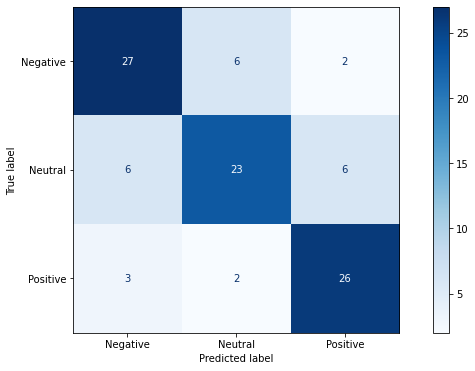

Model Performance metrics:

Accuracy: 0.8020
Precision: 0.8021
Recall: 0.8071
F1 Score: 0.8020


Model Classification report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79        35
           1       0.80      0.69      0.74        35
           2       0.83      0.94      0.88        31

    accuracy                           0.80       101
   macro avg       0.80      0.81      0.80       101
weighted avg       0.80      0.80      0.80       101



Prediction Confusion Matrix:


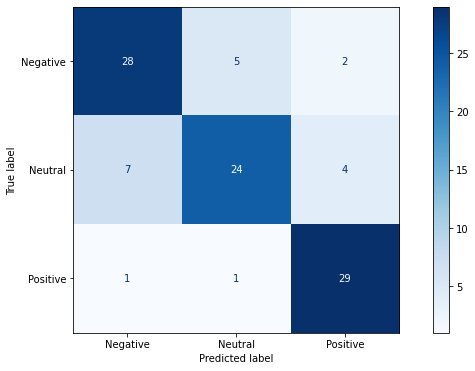

Model Performance metrics:

Accuracy: 0.7723
Precision: 0.7775
Recall: 0.7736
F1 Score: 0.7742


Model Classification report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76        35
           1       0.78      0.71      0.75        35
           2       0.83      0.81      0.82        31

    accuracy                           0.77       101
   macro avg       0.78      0.77      0.77       101
weighted avg       0.78      0.77      0.77       101



Prediction Confusion Matrix:


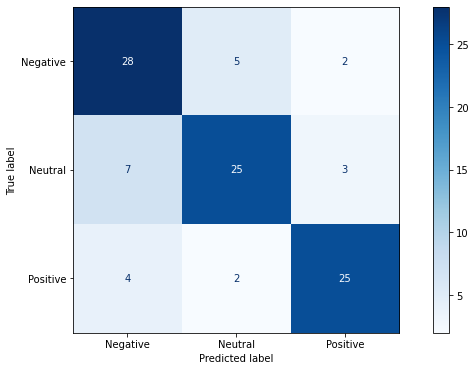

Model Performance metrics:

Accuracy: 0.7723
Precision: 0.7819
Recall: 0.7736
F1 Score: 0.7767


Model Classification report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        35
           1       0.70      0.74      0.72        35
           2       0.89      0.81      0.85        31

    accuracy                           0.77       101
   macro avg       0.78      0.77      0.78       101
weighted avg       0.78      0.77      0.77       101



Prediction Confusion Matrix:


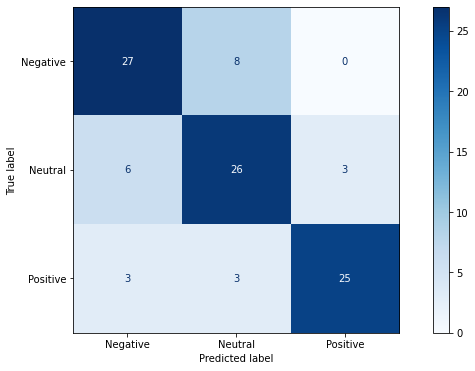

Model Performance metrics:

Accuracy: 0.7525
Precision: 0.7527
Recall: 0.7558
F1 Score: 0.7511


Model Classification report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        35
           1       0.76      0.63      0.69        35
           2       0.74      0.84      0.79        31

    accuracy                           0.75       101
   macro avg       0.75      0.76      0.75       101
weighted avg       0.75      0.75      0.75       101



Prediction Confusion Matrix:


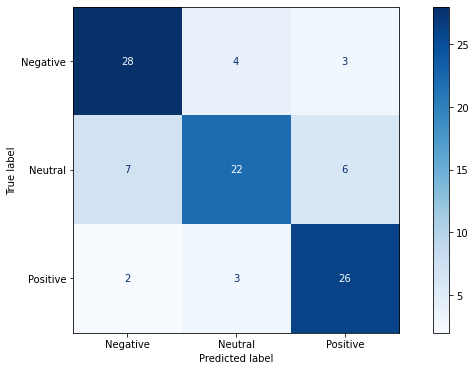




============ Transformer vinai/bertweet-base evaluation metrics ============



Mean Testing Accuracy: 0.7703, std: 0.0181
Mean Testing Precision: 0.7733, std: 0.0189
Mean Testing Recall: 0.7731, std: 0.0187
Mean Testing F1 Score: 0.7713, std: 0.0187




In [33]:
evaluate_all_models_to_test(models_to_test_names, all_models_performance_metrics, models_tokenisers, models_max_lens)

# Do Inference on Tweets Dataset

This section of code can be used to annotate/predict sentiments for a dataset of tweets which can be saved to do experiments and further analysis of the sentiment distribution. 

In [34]:
def create_tweets_dataloader_for_inference(tweets: np.ndarray, max_len: int, sampler: Sampler, batch_size: int, tokenizer: AutoTokenizer) -> DataLoader:
    """
    This method created a dataloader object given parameters max number of tokens, 
    type of the sampler, batch size and model's tokenizer.  
    """
    input_ids, attention_masks = encode_tweets_for_inference(tweets, max_len, tokenizer)
    dataset = TensorDataset(input_ids, attention_masks)
    
    dataloader = DataLoader(
            dataset, 
            sampler = sampler(dataset), 
            batch_size = batch_size 
    )
    
    return dataloader


def encode_tweets_for_inference(tweets: np.ndarray, max_len: int, tokenizer: AutoTokenizer) -> tuple:
    """
    This method tokenises each tweet with the given model tokenizer. It uses padding 
    and truncation if the tweets are too short or too long respectively. 
    Tokenised tweet representations are returned. 
    """
    input_ids = []
    attention_masks = []
    
    for tweet in tweets:
        encoded_dict = tokenizer.encode_plus(
                            tweet,                      
                            add_special_tokens = True, 
                            max_length = max_len,           
                            padding='max_length',
                            return_attention_mask = True,  
                            truncation=True,
                            return_tensors = 'pt',    
                       )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks


def make_predictions_for_inference(dataloader: DataLoader, device: torch.device, model: AutoModelForSequenceClassification) -> np.ndarray:
    """
    This method makes sentiment predictions for the whole dataset of tweets. Dataloader
    is iterated through to predict the results of a batch of tweets to not fill the whole 
    available memory.  
    """
    model.eval()

    predictions = []
    
    for batch in dataloader:
        logits = batch_predict_for_inference(batch, device, model)
        predictions.append(logits)
    
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    return flat_predictions

    
def batch_predict_for_inference(batch: torch.Tensor, device: torch.device, model: AutoModelForSequenceClassification) -> np.ndarray:
    """
    Generate and return model predictions for the batch of tweets.
    """
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        result = model(b_input_ids, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits

    logits = logits.detach().cpu().numpy()
    
    return logits


In [35]:
def do_inference_for_tweets(file_path: str, save_path: str, tweets_access_key: str="Tweet") -> pd.DataFrame:
    """
    This method makes sentiment predictions for the whole dataset of tweets. Dataloader is created 
    and iterated through to predict the results of a batch of tweets to not fill the whole 
    available memory. Predictions are written to a json file. 
    """
    start_time = time.time()

    tweets_df = open_json_file(file_path)
    tweets = tweets_df[tweets_access_key].values

    # Read a model from local storage which is used to make predictions 
    output_dir = f'{BASE_PATH}/model_save'
    model = AutoModelForSequenceClassification.from_pretrained(output_dir)
    tokenizer = AutoTokenizer.from_pretrained(output_dir)
    model.to(device)

    print(f"Tweets number: {len(tweets)}")
    max_len = get_max_tweet_length(tweets, tokenizer)

    # Create a dataloader from the loaded data
    dataloader = create_tweets_dataloader_for_inference(tweets, max_len, SequentialSampler, batch_size, tokenizer)    
    predictions = make_predictions_for_inference(dataloader, device, model)

    tweets_df["Predicted Sentiment"] = predictions
    
    # Save tweets with predictions
    tweets_df.to_json(save_path, orient="records", indent=4)

    end_time = time.time() - start_time
    print(f"\nTime taken overall for all tweets inference: {end_time:.3f} seconds")

    return tweets_df

Uncomment the code below, provide `file_path` and `save_path` to be able to make inference for a chosen dataset.

In [36]:
# # do inference for all collected tweets
# do_inference_for_tweets(file_path=..., save_path="...", tweets_access_key="Tweet")

# # do inference for topic labelled tweets
# do_inference_for_tweets(file_path=..., save_path="...", tweets_access_key="Document")

# Ensemble of Transformers

## Define Required Constants for Ensemble Learning 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Max length of tokens in tweets: 117


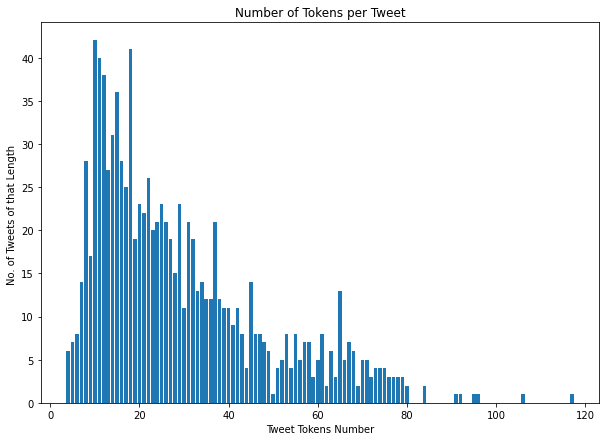

In [37]:
number_of_models = 20
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
test_size_val = 0.2
max_len = get_max_tweet_length(tweets_df["Tweet"].values, tokenizer)
torch.cuda.empty_cache()

In [38]:
def train_ensemble_models(number_of_models: int, model_name: str, tokenizer: AutoTokenizer, test_size_val: float, max_len: int, tweets_df_train: pd.DataFrame) -> tuple:
    """
    This method defines the pipeline of training the ensemble. Given number of models 
    is trained, their results are preserved and returned. As well, all models performance 
    are combined to an ensemble using the majority voting in a hope to increase the performance 
    compared to a single model. 
    Each model is trained after taking a random (with a seed) bootstrap with replacement from a  
    training data set.
    """
    # Split data into training and validation sets for ensemble learning. Validation set 
    # is going to stay the same for all models
    tweets_df_training, tweets_df_validation = train_test_split(tweets_df_train, test_size=test_size_val, random_state=test_split_random_state, stratify=tweets_df_train["Sentiment"])

    training_tweets = tweets_df_training["Tweet"].values
    training_labels = tweets_df_training["Sentiment"].values

    # Create a dataloader for the validation dataset
    validation_tweets = tweets_df_validation["Tweet"].values
    validation_labels = tweets_df_validation["Sentiment"].values
    validation_dataloader = create_tweets_dataloader(validation_tweets, validation_labels, max_len, SequentialSampler, batch_size, tokenizer)

    # Init arrays for storing statistics for each model
    model_eval_probabilities = np.zeros([number_of_models, len(validation_tweets), 3])
    model_eval_accuracies = np.zeros([number_of_models])
    
    # Store statistics of the ensemble performance continuously when training new models
    ensemble_performance_on_number_of_models = np.zeros([number_of_models])
    models_mean_performance_on_number_of_models = np.zeros([number_of_models])
    models_std_performance_on_number_of_models = np.zeros([number_of_models])
    
    # Init seeds for each model
    seeds = np.arange(init_seed_val, init_seed_val + number_of_models, 1)
    indices = np.arange(0, len(training_tweets), 1)

    for i in range(number_of_models):
        seed_val = seeds[i]
        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        
        # Define a model
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, 
            num_labels = 3, 
            output_attentions = False, 
            output_hidden_states = False
        )

        model = model.to(device)

        # Do a bootstrap with replacement
        random_indices = np.random.choice(indices, len(training_tweets), replace=True)

        # Take bootstrapped data for each model
        tweets_train = np.take(training_tweets, random_indices, axis=0)
        labels_train = np.take(training_labels, random_indices, axis=0)

        # Create a dataloader for the bootstrapped training dataset
        train_dataloader = create_tweets_dataloader(tweets_train, labels_train, max_len, RandomSampler, batch_size, tokenizer)
        total_steps = len(train_dataloader) * epochs

        # Create an AdamW optimizer and linear scheduler
        optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=weight_decay)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
        
        # Define Early Stopping object to terminate early if val loss is not getting better
        early_stopping = EarlyStopping(patience=patience, tokenizer=tokenizer, true_labels=validation_labels)

        # Train and evaluate with validation set the model
        model, training_stats_for_model = train(total_steps, epochs, model, train_dataloader, device, optimizer, scheduler, validation_dataloader, early_stopping)
        
        # Extract model predictions and metrics
        epochs_number = len(training_stats_for_model)
        predicted_labels = training_stats_for_model[epochs_number-1]['Evaluation Predictions']
        probabilities = np.array(training_stats_for_model[epochs_number-1]["Probabilities"])
        model_accuracy = training_stats_for_model[epochs_number-1]["Valid. Accur."]

        model_eval_probabilities[i] = probabilities
        model_eval_accuracies[i] = model_accuracy

        # Plot the model performance in terms of loss and accuracy 
        plot_losses(training_stats_for_model)
        plot_accuracies(training_stats_for_model)
        
        # Save the model in local storage
        output_path = f"./ensemble_models/{model_name.replace('/', '-')}_model_{i+1}"
        save_model(output_path, model, tokenizer)
        
        # Obtain the accuracy reached by the model so far
        ensemble_eval_accuracy, ensemble_predictions = get_ensemble_accuracy(model_eval_probabilities[:i+1], validation_tweets, validation_labels)
        
        ensemble_performance_on_number_of_models[i] = ensemble_eval_accuracy

        # Calculate ensemble performance so far after taking (i + 1) models
        models_mean_performance_on_number_of_models[i] = model_eval_accuracies[:i+1].mean()
        models_std_performance_on_number_of_models[i] = model_eval_accuracies[:i+1].std()
    
    print(f"Display Ensemble validation performance metrics after training {number_of_models} models")
    display_model_performance_metrics(validation_labels, ensemble_predictions)
    
    return model_eval_accuracies, ensemble_performance_on_number_of_models, models_mean_performance_on_number_of_models, models_std_performance_on_number_of_models
    
    
def get_ensemble_accuracy(model_probabilities: np.ndarray, tweets: np.ndarray, labels: np.ndarray) -> tuple:
    """
    This method computes the ensemble performance using majority voting (averaging probabilities 
    for each tweet) given current number of models. 
    """
    # To make it easier to add up probabilities for each tweet
    # instead of having an array of model tweet predictions, I have an array of tweet predictions for models
    # which can be more easily used to iterate through predictions
    model_probabilities_transposed = np.transpose(model_probabilities, (1, 0, 2))
    final_predictions = np.zeros([len(tweets)])

    for j, model_predictions in enumerate(model_probabilities_transposed):
        probabilities = np.zeros(3)
        
        # For each tweet, go through each model's prediction in probabilities, which are summed over here.
        for probs in model_predictions:
            for label, class_prob in enumerate(probs):
                probabilities[label] += class_prob
        
        # One which shows highest probability aggregation is chosen by an ensemble
        final_predictions[j] = np.argmax(probabilities)
    
    ensemble_accuracy = (final_predictions == labels).sum()/len(labels)
    return ensemble_accuracy, final_predictions

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.00
  Training epoch took: 0:00:09
  Training Accuracy: 0.52

Running Validation...
  Validation Accuracy: 0.58
Validation Loss: 0.95
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.63
  Training epoch took: 0:00:09
  Training Accuracy: 0.79

Running Validation...
  Validation Accuracy: 0.62
Validation Loss: 0.90
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.32
  Training epoch took: 0:00:09
  Training Accuracy: 0.92

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 1.03
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.14
  Training epoch took: 0:00:09
  Training Accuracy: 0.96

Running Validation...
  Validation Accuracy: 0.63
Validation Loss: 1.30
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.05


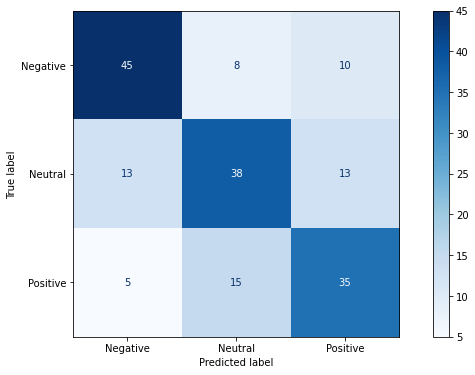

  Validation Accuracy: 0.65
Validation Loss: 1.87
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


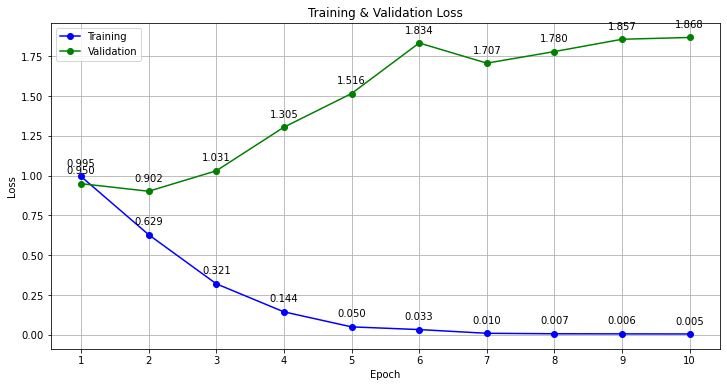

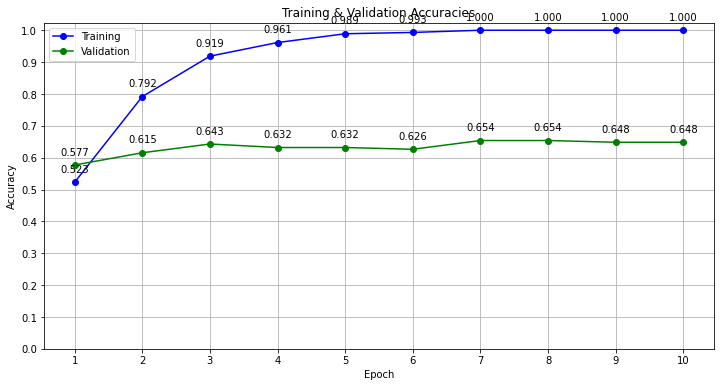

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.00
  Training epoch took: 0:00:09
  Training Accuracy: 0.49

Running Validation...
  Validation Accuracy: 0.60
Validation Loss: 0.88
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.63
  Training epoch took: 0:00:09
  Training Accuracy: 0.78

Running Validation...
  Validation Accuracy: 0.66
Validation Loss: 0.83
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.27
  Training epoch took: 0:00:09
  Training Accuracy: 0.94

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 1.03
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.09
  Training epoch took: 0:00:09
  Training Accuracy: 0.98

Running Validation...
  Validation Accuracy: 0.68
Validation Loss: 1.23
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.04


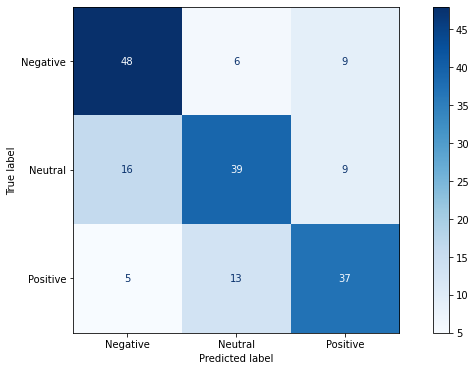

  Validation Accuracy: 0.68
Validation Loss: 1.73
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


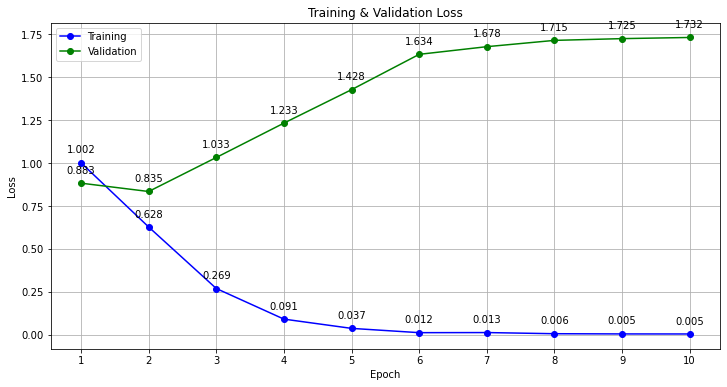

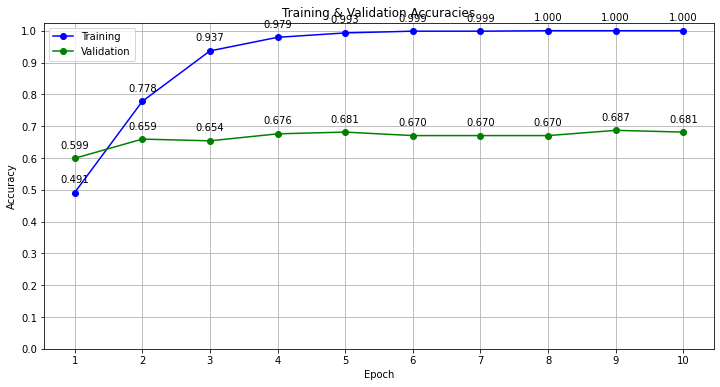

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.01
  Training epoch took: 0:00:09
  Training Accuracy: 0.50

Running Validation...
  Validation Accuracy: 0.58
Validation Loss: 0.95
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.60
  Training epoch took: 0:00:09
  Training Accuracy: 0.80

Running Validation...
  Validation Accuracy: 0.69
Validation Loss: 0.83
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.26
  Training epoch took: 0:00:09
  Training Accuracy: 0.94

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 0.91
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.14
  Training epoch took: 0:00:09
  Training Accuracy: 0.97

Running Validation...
  Validation Accuracy: 0.67
Validation Loss: 1.19
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.07


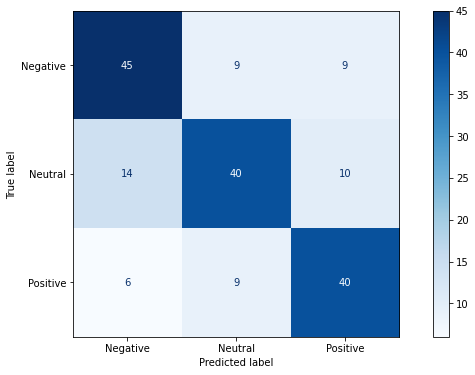

  Validation Accuracy: 0.69
Validation Loss: 1.58
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


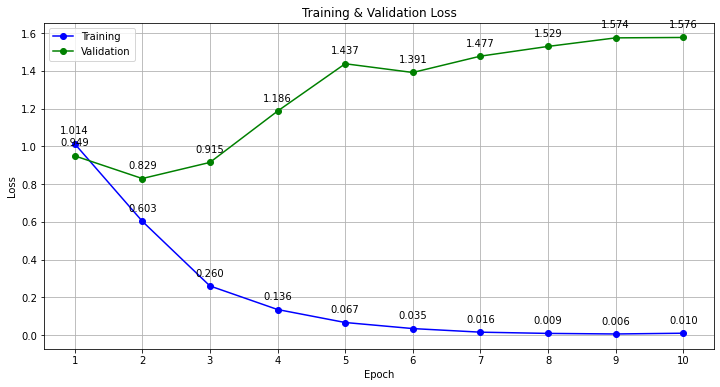

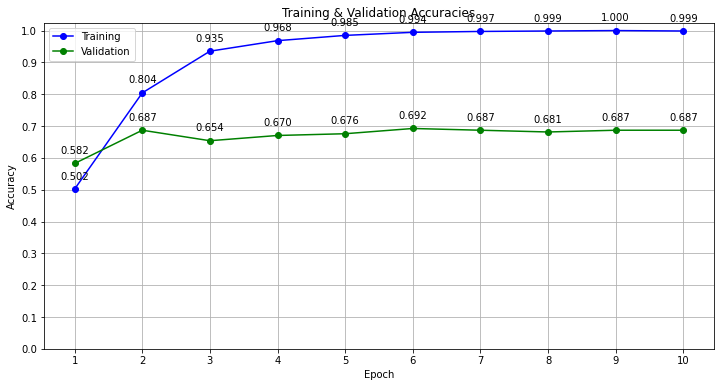

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 0.99
  Training epoch took: 0:00:09
  Training Accuracy: 0.51

Running Validation...
  Validation Accuracy: 0.62
Validation Loss: 0.89
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.53
  Training epoch took: 0:00:09
  Training Accuracy: 0.83

Running Validation...
  Validation Accuracy: 0.66
Validation Loss: 0.82
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.27
  Training epoch took: 0:00:09
  Training Accuracy: 0.93

Running Validation...
  Validation Accuracy: 0.63
Validation Loss: 1.06
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.16
  Training epoch took: 0:00:09
  Training Accuracy: 0.96

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 1.22
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.07


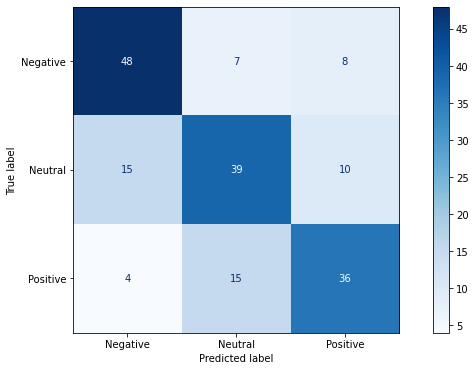

  Validation Accuracy: 0.68
Validation Loss: 1.64
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


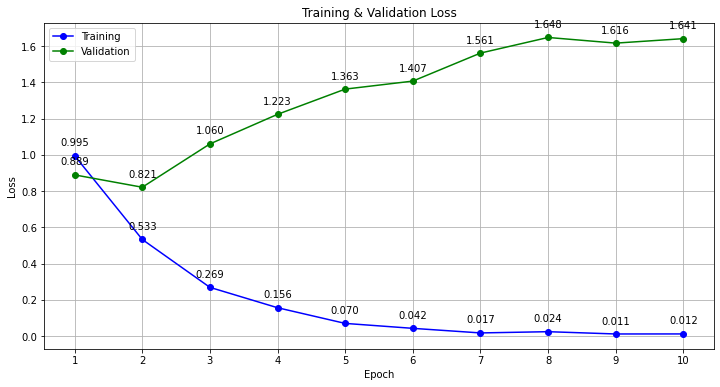

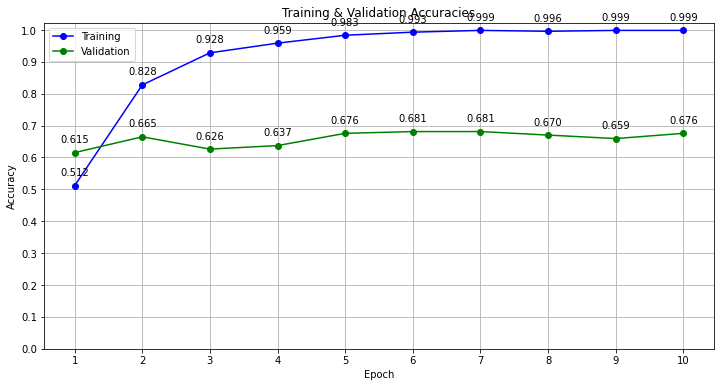

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.01
  Training epoch took: 0:00:09
  Training Accuracy: 0.48

Running Validation...
  Validation Accuracy: 0.58
Validation Loss: 0.89
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.61
  Training epoch took: 0:00:09
  Training Accuracy: 0.80

Running Validation...
  Validation Accuracy: 0.66
Validation Loss: 0.83
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.31
  Training epoch took: 0:00:09
  Training Accuracy: 0.93

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 1.05
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.16
  Training epoch took: 0:00:09
  Training Accuracy: 0.96

Running Validation...
  Validation Accuracy: 0.68
Validation Loss: 1.24
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.06


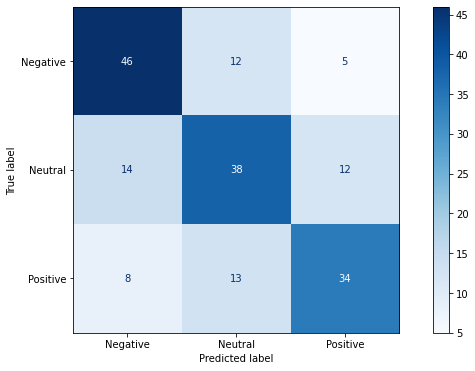

  Validation Accuracy: 0.65
Validation Loss: 1.72
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


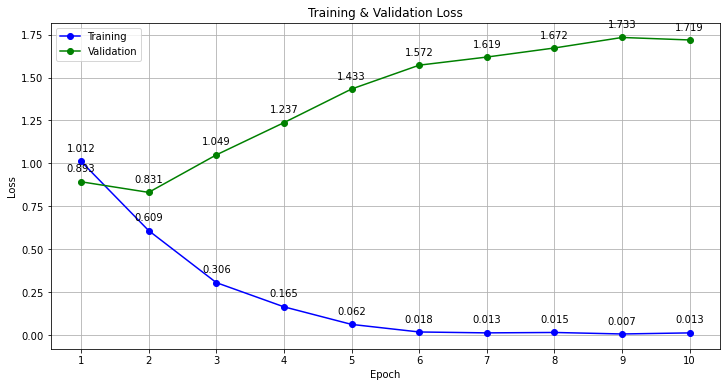

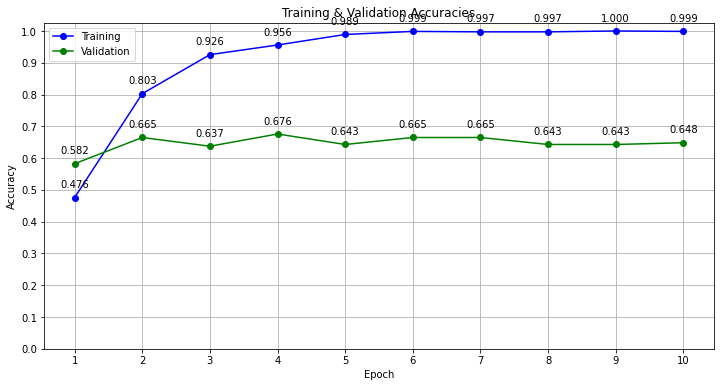

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.03
  Training epoch took: 0:00:09
  Training Accuracy: 0.47

Running Validation...
  Validation Accuracy: 0.53
Validation Loss: 0.96
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.62
  Training epoch took: 0:00:09
  Training Accuracy: 0.78

Running Validation...
  Validation Accuracy: 0.69
Validation Loss: 0.83
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.33
  Training epoch took: 0:00:09
  Training Accuracy: 0.90

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 0.93
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.15
  Training epoch took: 0:00:09
  Training Accuracy: 0.97

Running Validation...
  Validation Accuracy: 0.68
Validation Loss: 1.10
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.07


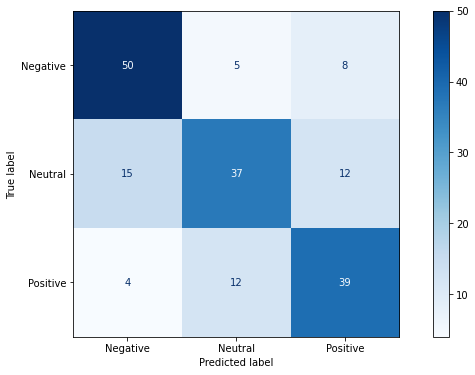

  Validation Accuracy: 0.69
Validation Loss: 1.61
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


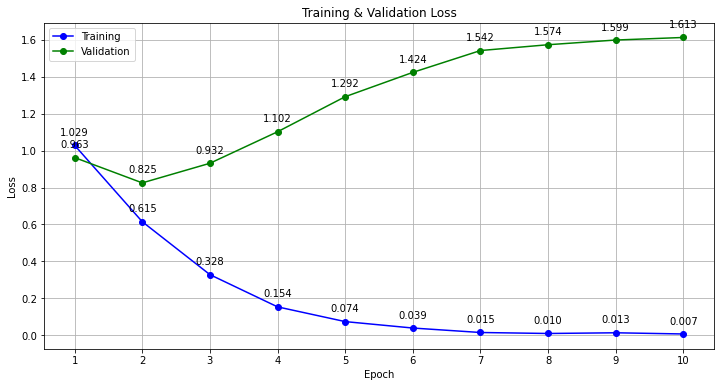

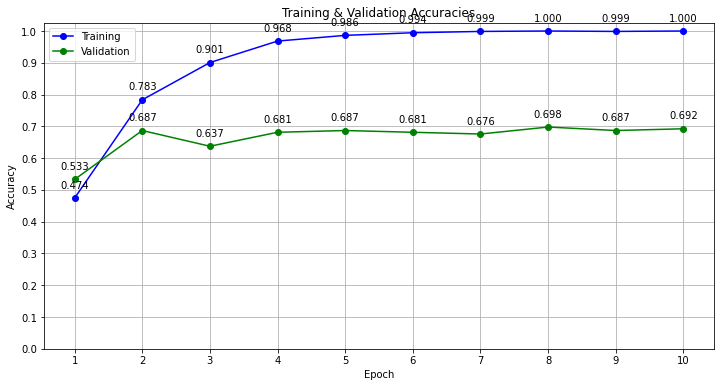

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.01
  Training epoch took: 0:00:09
  Training Accuracy: 0.48

Running Validation...
  Validation Accuracy: 0.53
Validation Loss: 0.97
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.61
  Training epoch took: 0:00:09
  Training Accuracy: 0.79

Running Validation...
  Validation Accuracy: 0.69
Validation Loss: 0.80
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.25
  Training epoch took: 0:00:09
  Training Accuracy: 0.93

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 0.99
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.13
  Training epoch took: 0:00:09
  Training Accuracy: 0.98

Running Validation...
  Validation Accuracy: 0.66
Validation Loss: 1.21
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.04


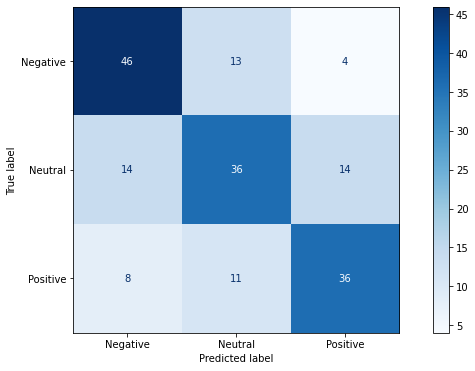

  Validation Accuracy: 0.65
Validation Loss: 1.75
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


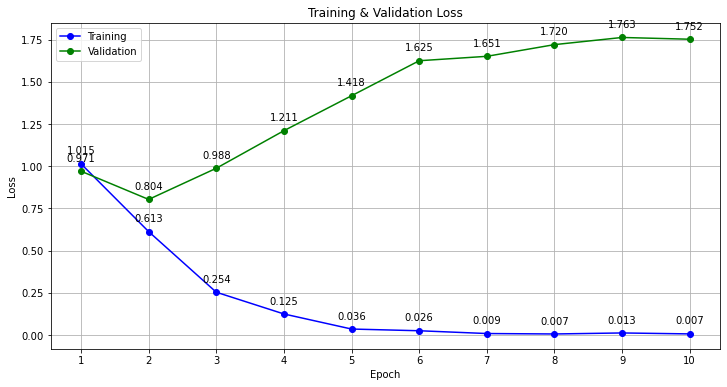

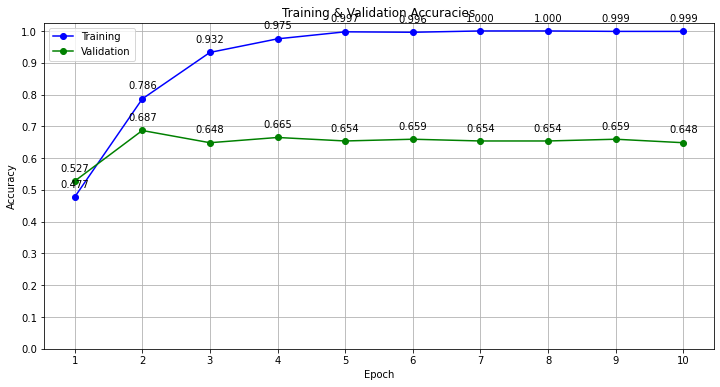

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.01
  Training epoch took: 0:00:09
  Training Accuracy: 0.48

Running Validation...
  Validation Accuracy: 0.53
Validation Loss: 0.95
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.60
  Training epoch took: 0:00:09
  Training Accuracy: 0.80

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 0.86
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.30
  Training epoch took: 0:00:09
  Training Accuracy: 0.92

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 1.02
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.14
  Training epoch took: 0:00:09
  Training Accuracy: 0.96

Running Validation...
  Validation Accuracy: 0.63
Validation Loss: 1.28
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.05


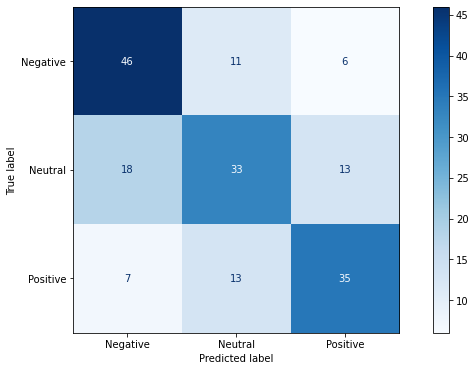

  Validation Accuracy: 0.63
Validation Loss: 1.89
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


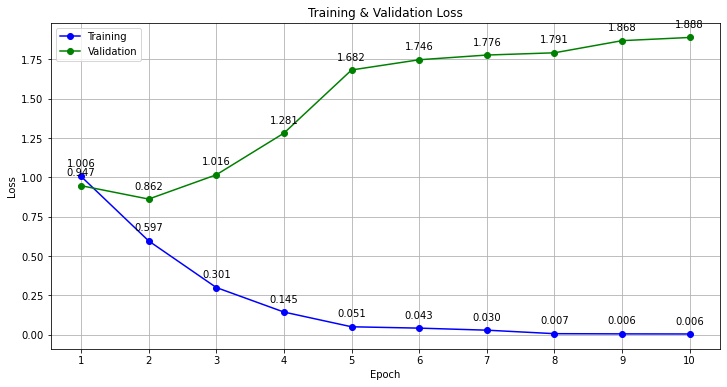

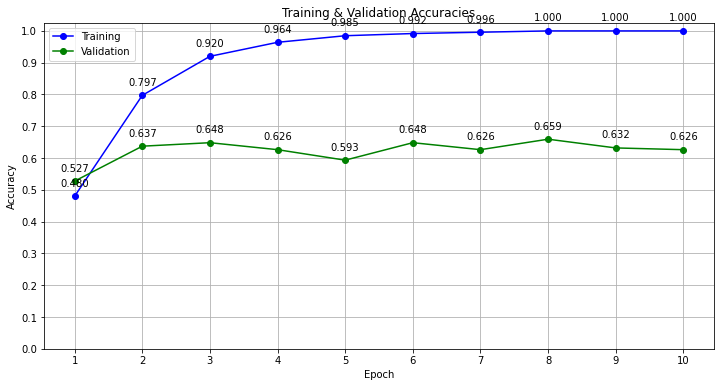

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.03
  Training epoch took: 0:00:09
  Training Accuracy: 0.48

Running Validation...
  Validation Accuracy: 0.44
Validation Loss: 1.03
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.78
  Training epoch took: 0:00:09
  Training Accuracy: 0.68

Running Validation...
  Validation Accuracy: 0.60
Validation Loss: 0.96
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.47
  Training epoch took: 0:00:09
  Training Accuracy: 0.85

Running Validation...
  Validation Accuracy: 0.60
Validation Loss: 0.95
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.27
  Training epoch took: 0:00:09
  Training Accuracy: 0.93

Running Validation...
  Validation Accuracy: 0.63
Validation Loss: 1.05
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.13


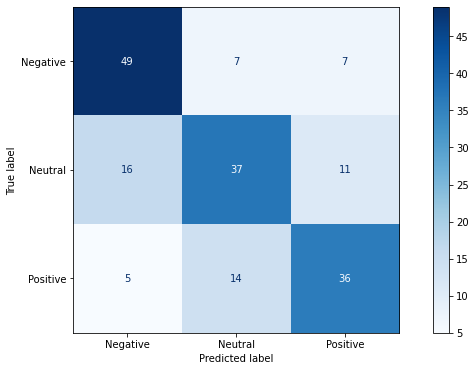

  Validation Accuracy: 0.67
Validation Loss: 1.69
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


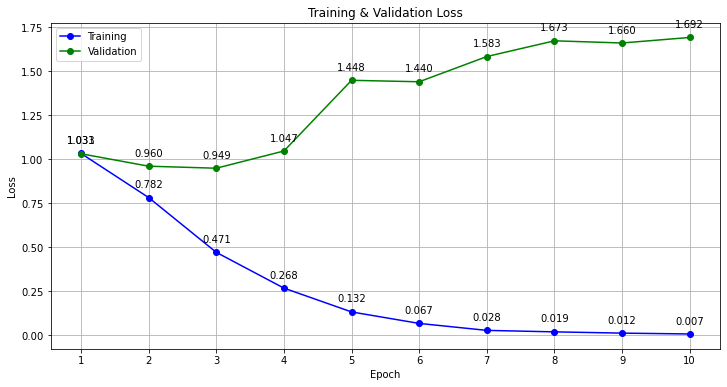

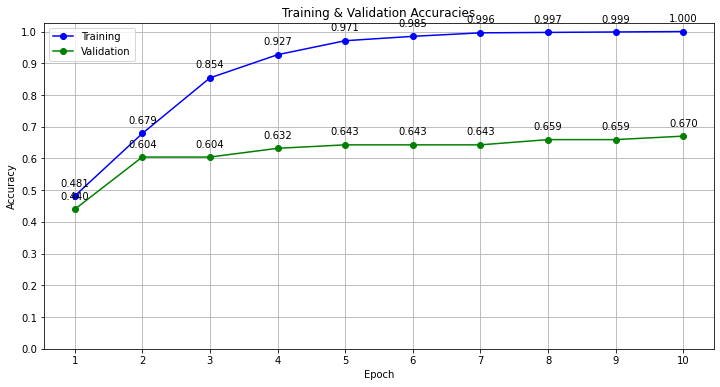

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.04
  Training epoch took: 0:00:09
  Training Accuracy: 0.46

Running Validation...
  Validation Accuracy: 0.51
Validation Loss: 1.00
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.73
  Training epoch took: 0:00:09
  Training Accuracy: 0.74

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 0.83
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.39
  Training epoch took: 0:00:09
  Training Accuracy: 0.88

Running Validation...
  Validation Accuracy: 0.63
Validation Loss: 0.91
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.21
  Training epoch took: 0:00:09
  Training Accuracy: 0.95

Running Validation...
  Validation Accuracy: 0.62
Validation Loss: 1.17
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.13


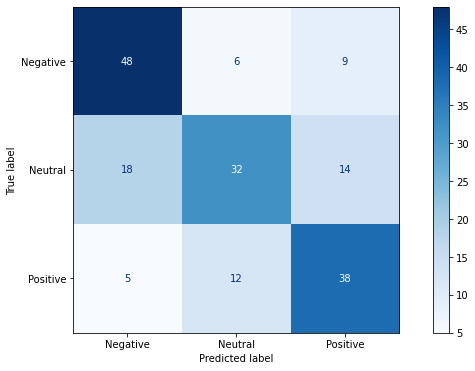

  Validation Accuracy: 0.65
Validation Loss: 1.68
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


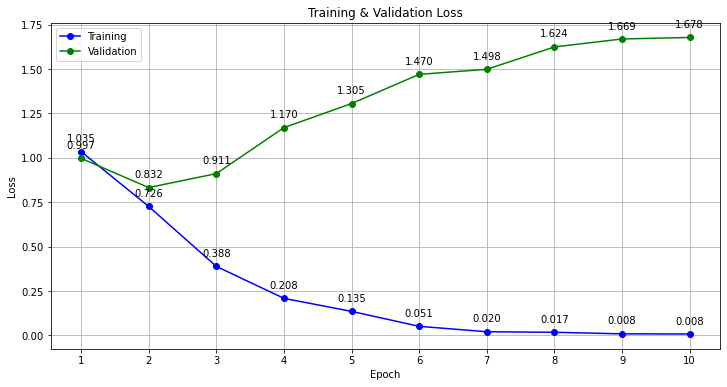

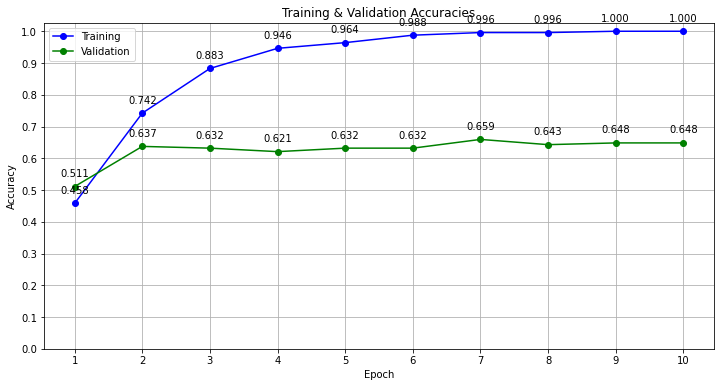

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.03
  Training epoch took: 0:00:09
  Training Accuracy: 0.47

Running Validation...
  Validation Accuracy: 0.53
Validation Loss: 0.97
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.65
  Training epoch took: 0:00:09
  Training Accuracy: 0.79

Running Validation...
  Validation Accuracy: 0.61
Validation Loss: 0.84
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.28
  Training epoch took: 0:00:09
  Training Accuracy: 0.93

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 1.01
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.14
  Training epoch took: 0:00:09
  Training Accuracy: 0.97

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 1.24
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.08


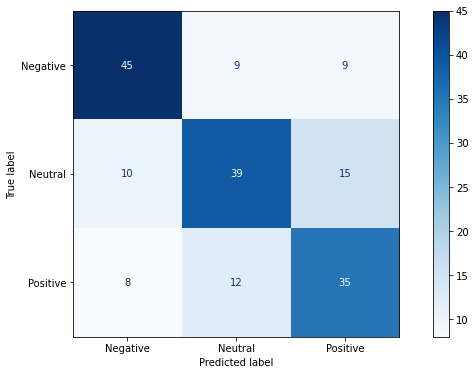

  Validation Accuracy: 0.65
Validation Loss: 1.78
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


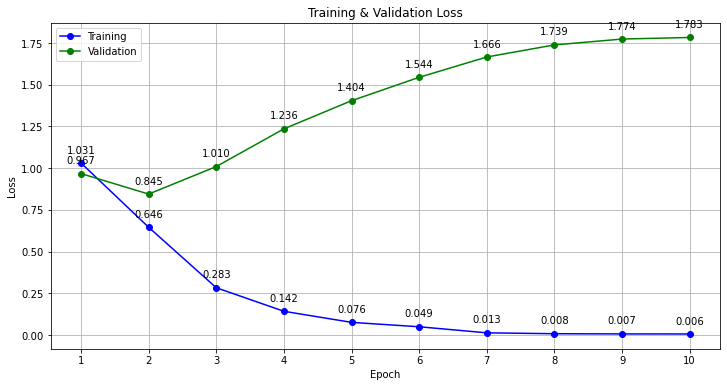

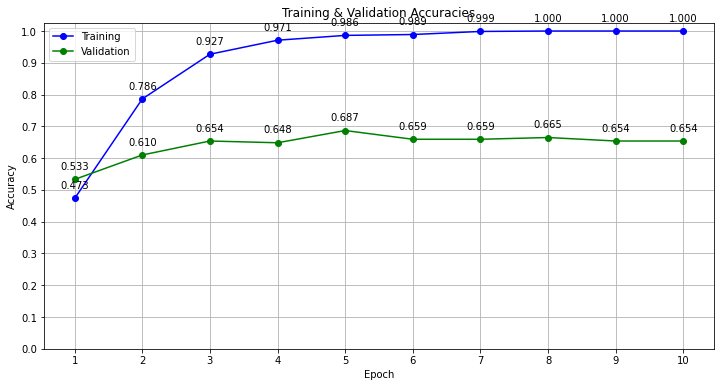

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.03
  Training epoch took: 0:00:09
  Training Accuracy: 0.46

Running Validation...
  Validation Accuracy: 0.62
Validation Loss: 0.94
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.68
  Training epoch took: 0:00:09
  Training Accuracy: 0.76

Running Validation...
  Validation Accuracy: 0.69
Validation Loss: 0.89
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.36
  Training epoch took: 0:00:09
  Training Accuracy: 0.89

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 1.01
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.17
  Training epoch took: 0:00:09
  Training Accuracy: 0.95

Running Validation...
  Validation Accuracy: 0.68
Validation Loss: 1.17
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.10


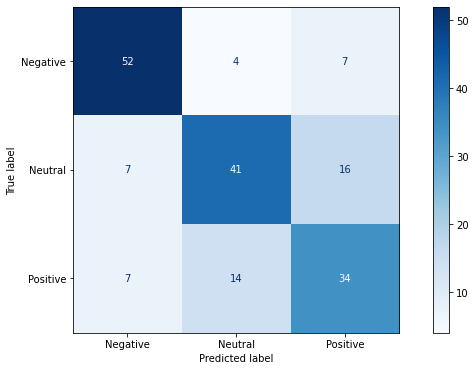

  Validation Accuracy: 0.70
Validation Loss: 1.62
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


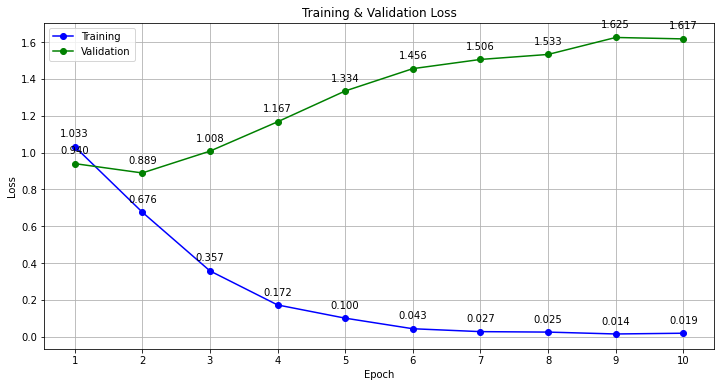

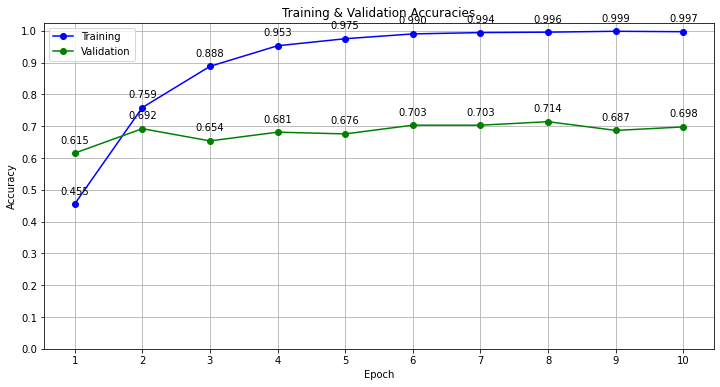

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.02
  Training epoch took: 0:00:09
  Training Accuracy: 0.47

Running Validation...
  Validation Accuracy: 0.53
Validation Loss: 0.97
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.65
  Training epoch took: 0:00:09
  Training Accuracy: 0.78

Running Validation...
  Validation Accuracy: 0.69
Validation Loss: 0.76
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.34
  Training epoch took: 0:00:09
  Training Accuracy: 0.91

Running Validation...
  Validation Accuracy: 0.68
Validation Loss: 0.86
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.16
  Training epoch took: 0:00:09
  Training Accuracy: 0.96

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 1.24
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.09


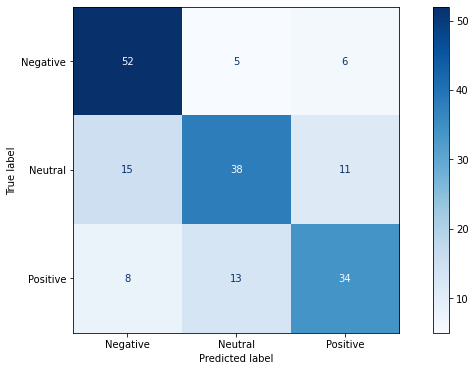

  Validation Accuracy: 0.68
Validation Loss: 1.59
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


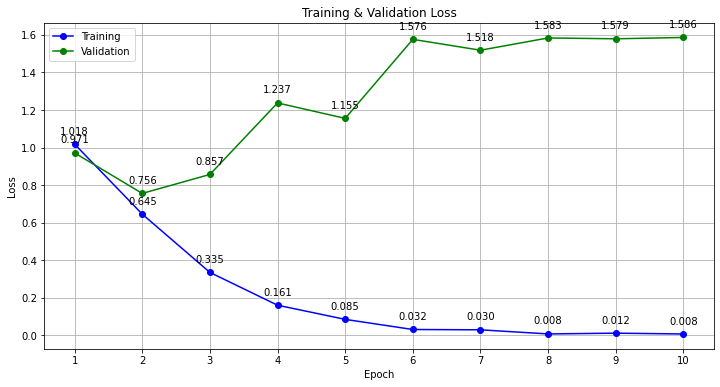

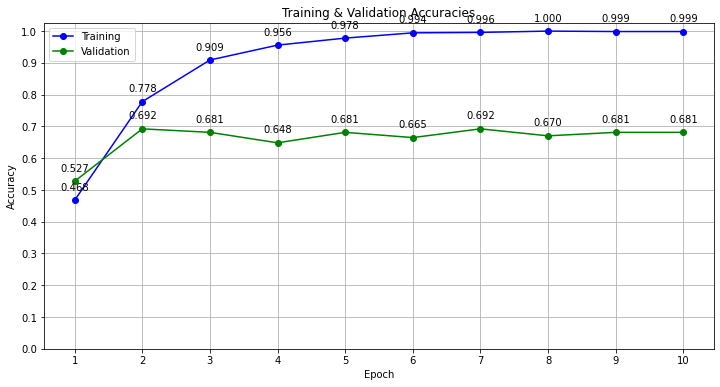

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.02
  Training epoch took: 0:00:09
  Training Accuracy: 0.50

Running Validation...
  Validation Accuracy: 0.56
Validation Loss: 0.93
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.66
  Training epoch took: 0:00:09
  Training Accuracy: 0.77

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 0.89
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.36
  Training epoch took: 0:00:09
  Training Accuracy: 0.89

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 0.93
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.15
  Training epoch took: 0:00:09
  Training Accuracy: 0.97

Running Validation...
  Validation Accuracy: 0.63
Validation Loss: 1.26
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.09


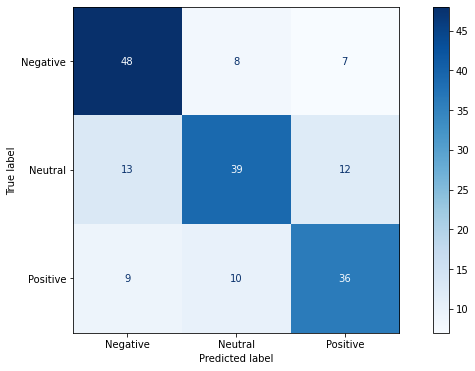

  Validation Accuracy: 0.68
Validation Loss: 1.55
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


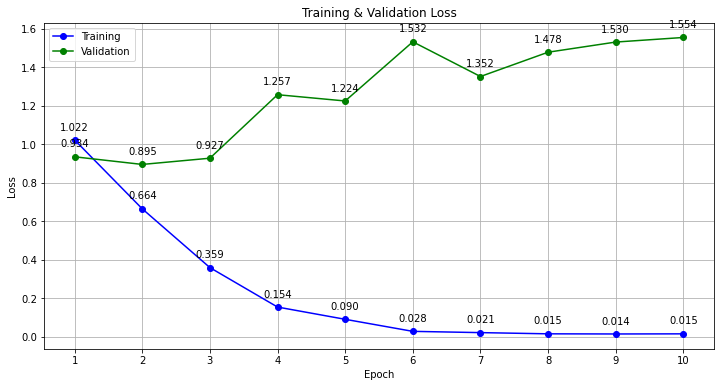

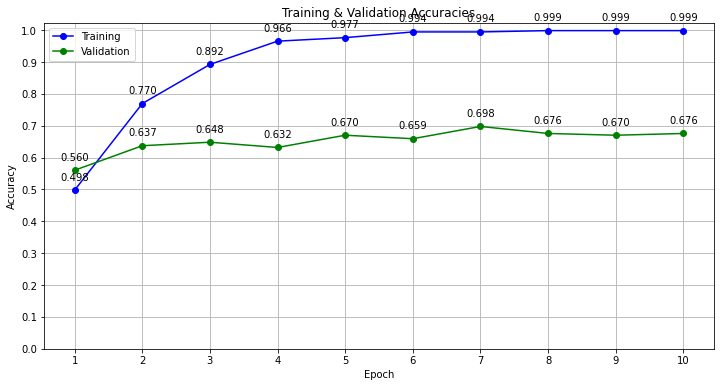

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.01
  Training epoch took: 0:00:09
  Training Accuracy: 0.48

Running Validation...
  Validation Accuracy: 0.58
Validation Loss: 0.93
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.59
  Training epoch took: 0:00:09
  Training Accuracy: 0.81

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 0.91
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.32
  Training epoch took: 0:00:09
  Training Accuracy: 0.92

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 1.08
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.17
  Training epoch took: 0:00:09
  Training Accuracy: 0.96

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 1.22
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.10


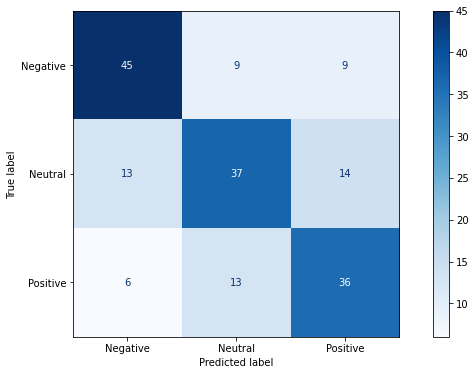

  Validation Accuracy: 0.65
Validation Loss: 1.81
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


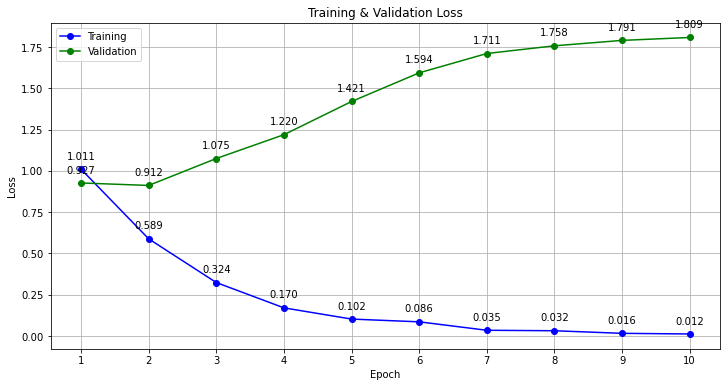

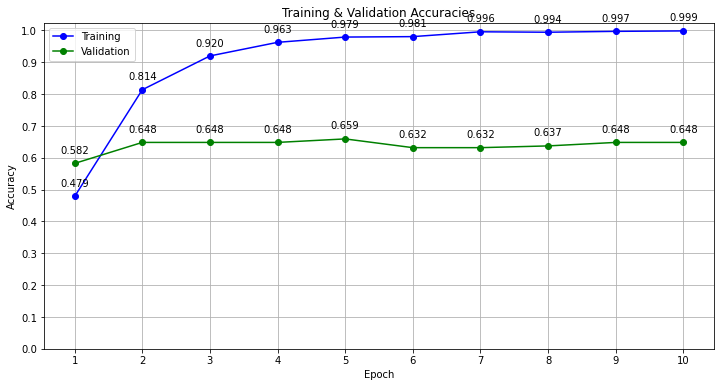

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.04
  Training epoch took: 0:00:09
  Training Accuracy: 0.45

Running Validation...
  Validation Accuracy: 0.53
Validation Loss: 1.00
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.73
  Training epoch took: 0:00:09
  Training Accuracy: 0.74

Running Validation...
  Validation Accuracy: 0.66
Validation Loss: 0.85
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.44
  Training epoch took: 0:00:09
  Training Accuracy: 0.87

Running Validation...
  Validation Accuracy: 0.62
Validation Loss: 0.98
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.22
  Training epoch took: 0:00:09
  Training Accuracy: 0.94

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 1.12
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.13


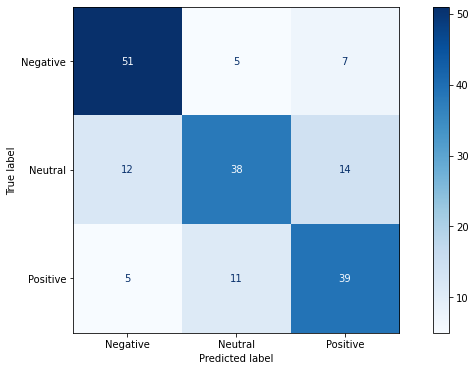

  Validation Accuracy: 0.70
Validation Loss: 1.39
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


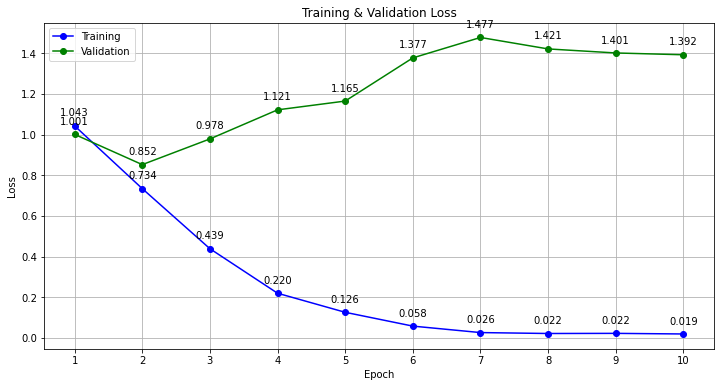

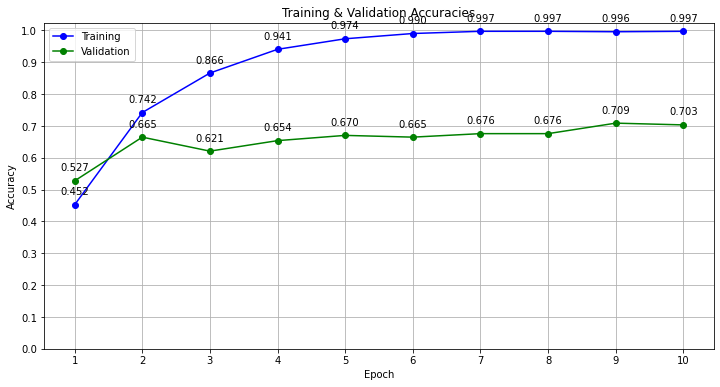

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.04
  Training epoch took: 0:00:09
  Training Accuracy: 0.44

Running Validation...
  Validation Accuracy: 0.59
Validation Loss: 0.95
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.71
  Training epoch took: 0:00:09
  Training Accuracy: 0.76

Running Validation...
  Validation Accuracy: 0.65
Validation Loss: 0.81
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.33
  Training epoch took: 0:00:09
  Training Accuracy: 0.91

Running Validation...
  Validation Accuracy: 0.67
Validation Loss: 0.88
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.13
  Training epoch took: 0:00:09
  Training Accuracy: 0.97

Running Validation...
  Validation Accuracy: 0.71
Validation Loss: 1.21
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.07


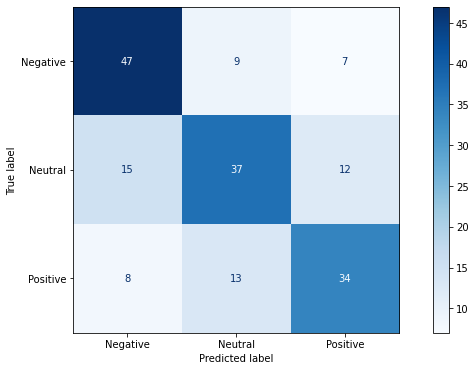

  Validation Accuracy: 0.65
Validation Loss: 1.83
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


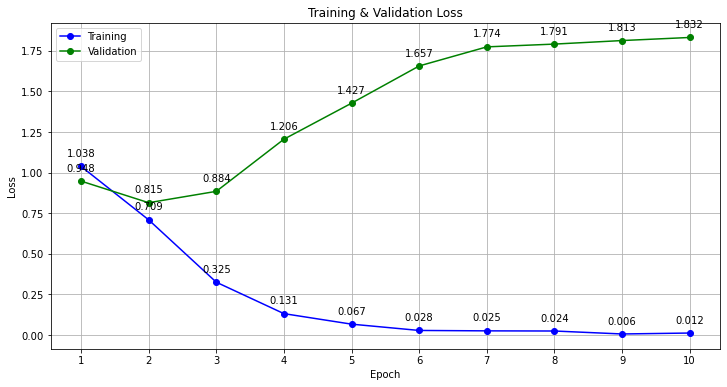

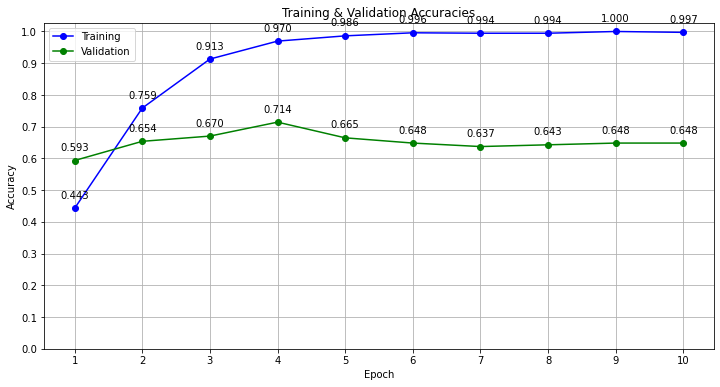

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.03
  Training epoch took: 0:00:09
  Training Accuracy: 0.48

Running Validation...
  Validation Accuracy: 0.52
Validation Loss: 0.98
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.72
  Training epoch took: 0:00:09
  Training Accuracy: 0.71

Running Validation...
  Validation Accuracy: 0.58
Validation Loss: 0.88
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.39
  Training epoch took: 0:00:09
  Training Accuracy: 0.88

Running Validation...
  Validation Accuracy: 0.66
Validation Loss: 0.87
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.17
  Training epoch took: 0:00:09
  Training Accuracy: 0.96

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 1.13
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.12


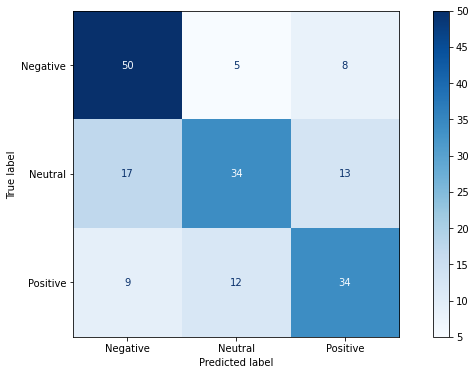

  Validation Accuracy: 0.65
Validation Loss: 1.69
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


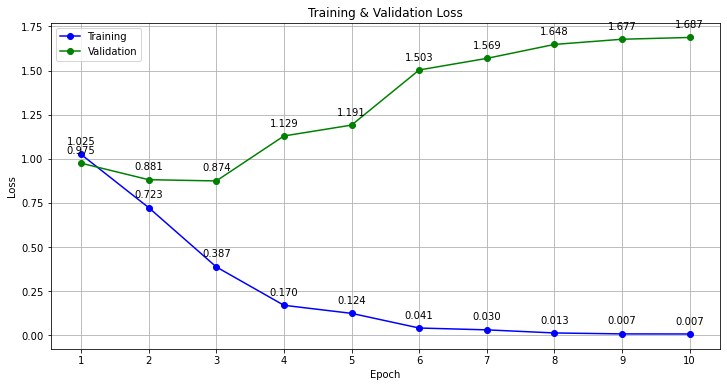

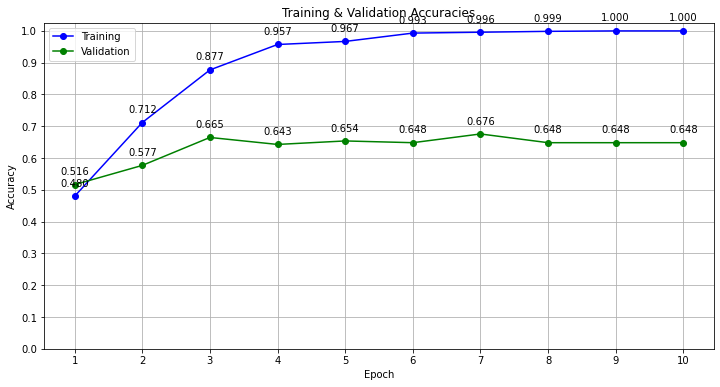

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.00
  Training epoch took: 0:00:09
  Training Accuracy: 0.53

Running Validation...
  Validation Accuracy: 0.53
Validation Loss: 0.94
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.64
  Training epoch took: 0:00:09
  Training Accuracy: 0.79

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 0.87
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.30
  Training epoch took: 0:00:09
  Training Accuracy: 0.91

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 1.03
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.15
  Training epoch took: 0:00:09
  Training Accuracy: 0.96

Running Validation...
  Validation Accuracy: 0.61
Validation Loss: 1.42
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.08


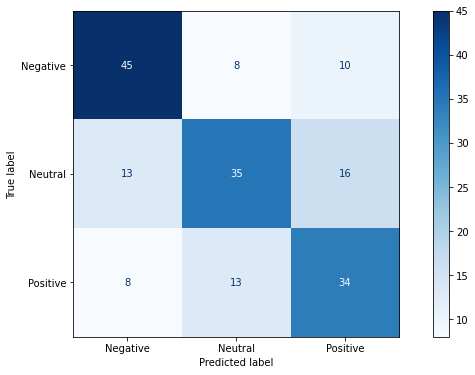

  Validation Accuracy: 0.63
Validation Loss: 2.02
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


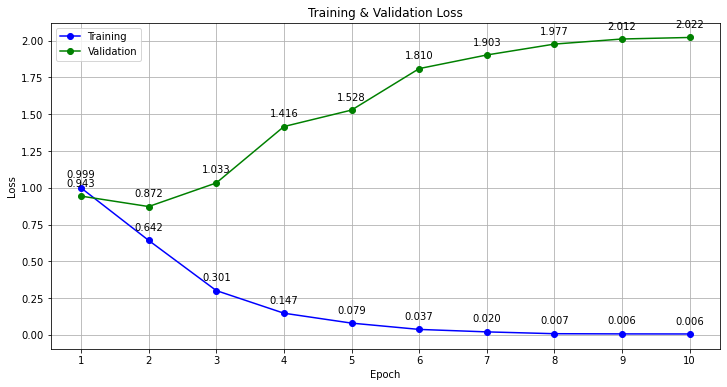

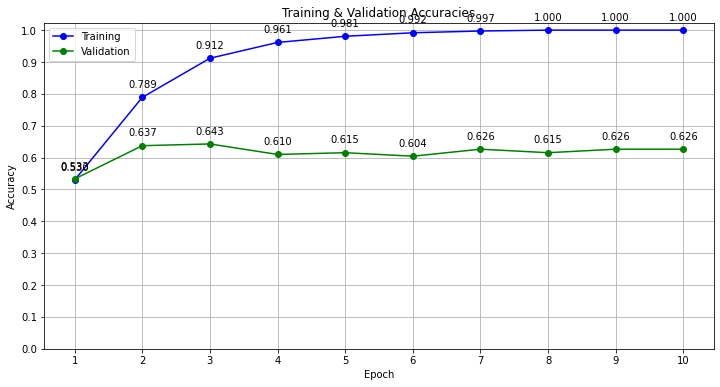

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/460 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 1.01
  Training epoch took: 0:00:09
  Training Accuracy: 0.48

Running Validation...
  Validation Accuracy: 0.58
Validation Loss: 0.95
Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.64
  Training epoch took: 0:00:09
  Training Accuracy: 0.78

Running Validation...
  Validation Accuracy: 0.64
Validation Loss: 0.82
Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.30
  Training epoch took: 0:00:09
  Training Accuracy: 0.93

Running Validation...
  Validation Accuracy: 0.68
Validation Loss: 0.94
Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.12
  Training epoch took: 0:00:09
  Training Accuracy: 0.98

Running Validation...
  Validation Accuracy: 0.63
Validation Loss: 1.40
Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.08


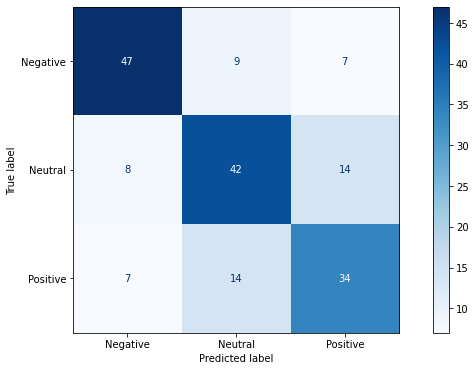

  Validation Accuracy: 0.68
Validation Loss: 1.71
Validation took: 0:00:01

Training complete!
Total training took 0:01:38 (h:mm:ss)


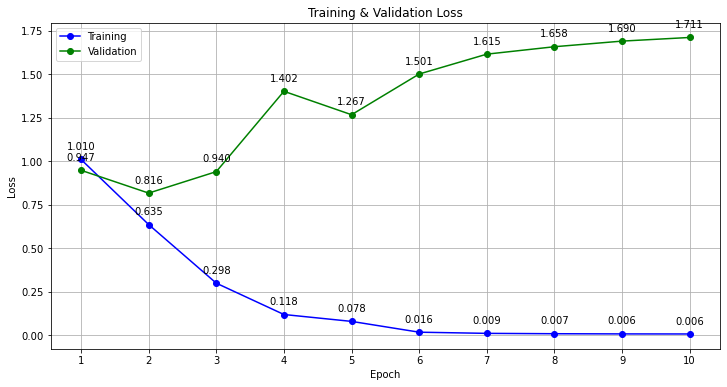

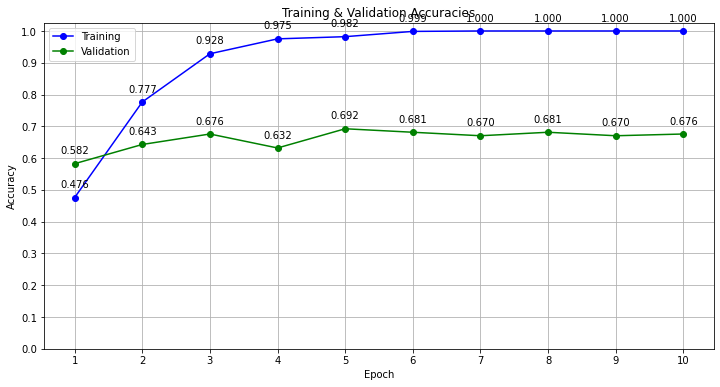

Display Ensemble validation performance metrics after training 20 models
Model Performance metrics:

Accuracy: 0.6868
Precision: 0.6845
Recall: 0.6867
F1 Score: 0.6837


Model Classification report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.76        63
           1       0.69      0.59      0.64        64
           2       0.64      0.67      0.65        55

    accuracy                           0.69       182
   macro avg       0.68      0.69      0.68       182
weighted avg       0.69      0.69      0.68       182



Prediction Confusion Matrix:


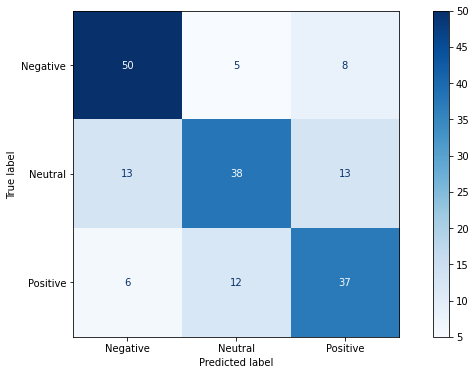

In [39]:
model_eval_accuracies, ensemble_performance_on_number_of_models, models_mean_performance_on_number_of_models, models_std_performance_on_number_of_models = train_ensemble_models(number_of_models, model_name, tokenizer, test_size_val, max_len, tweets_df_train)

In [40]:
def plot_ensemble_accuracy_per_number_of_models(number_of_models: int, ensemble_performance_on_number_of_models: np.ndarray, models_mean_performance_on_number_of_models: np.ndarray, models_std_performance_on_number_of_models: np.ndarray) -> None:
    """
    This method plots a graph showing how the accuracies of mean models (depending on the x axis 
    which denotes the number of models so far) and ensemble performance change over the trained number
    of models. A separate line is drawn for each.
    """
    x_axis_number_of_models = np.arange(1, number_of_models + 1, 1)
    
    plt.plot(x_axis_number_of_models, ensemble_performance_on_number_of_models, 'b-o', label="Ensemble Accuracy")
    plt.plot(x_axis_number_of_models, models_mean_performance_on_number_of_models, 'g-o', label="Mean Model Accuracy")
    
    # Plot the labels with respective accuracy for each data point
    for i, (ensemble_accuracy, mean_models_accuracy) in enumerate(zip(ensemble_performance_on_number_of_models, models_mean_performance_on_number_of_models)):
        train_label = f"{ensemble_accuracy:.3f}"

        plt.annotate(train_label,
             (i+1, ensemble_accuracy), 
             textcoords="offset points", 
             xytext=(0,10), 
             ha='center') 
        
        test_label = f"{mean_models_accuracy:.3f}"
        
        plt.annotate(test_label, 
             (i+1, mean_models_accuracy),
             textcoords="offset points", 
             xytext=(0,10), 
             ha='center')

    plt.xlabel("Number of Models")
    plt.ylabel("Accuracy")

    plt.xticks(range(1, number_of_models+1))
    
    # Uncomment to change ticks of the y axis  
    #  plt.yticks(np.arange(0.0, 1.1, 0.1))

    plt.legend()
    plt.grid()

    plt.show()
    

def show_model_accuracies(accuracies: np.ndarray) -> None:
    """
    This method goes through model achieved accuracies and displays them.
    """
    for i, accuracy in enumerate(accuracies):
        print(f"Model {i+1} accuracy: {accuracy*100:.2f}%")

    print(f"\nMean models accuracy: {accuracies.mean()*100:.2f}% +- {accuracies.std()*100:.2f}%")

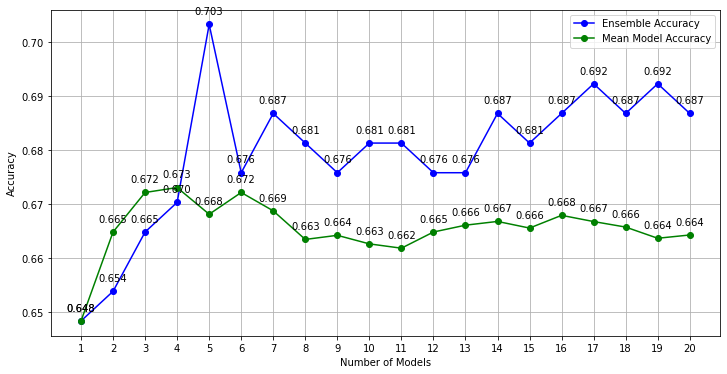

Model 1 accuracy: 64.84%
Model 2 accuracy: 68.13%
Model 3 accuracy: 68.68%
Model 4 accuracy: 67.58%
Model 5 accuracy: 64.84%
Model 6 accuracy: 69.23%
Model 7 accuracy: 64.84%
Model 8 accuracy: 62.64%
Model 9 accuracy: 67.03%
Model 10 accuracy: 64.84%
Model 11 accuracy: 65.38%
Model 12 accuracy: 69.78%
Model 13 accuracy: 68.13%
Model 14 accuracy: 67.58%
Model 15 accuracy: 64.84%
Model 16 accuracy: 70.33%
Model 17 accuracy: 64.84%
Model 18 accuracy: 64.84%
Model 19 accuracy: 62.64%
Model 20 accuracy: 67.58%

Mean models accuracy: 66.43% +- 2.20%


In [41]:
plot_ensemble_accuracy_per_number_of_models(number_of_models, ensemble_performance_on_number_of_models, models_mean_performance_on_number_of_models, models_std_performance_on_number_of_models)
show_model_accuracies(model_eval_accuracies)

In [42]:
def test_ensemble_models(number_of_models: int, tokenizer: AutoTokenizer, max_len: int, tweets_df_test: pd.DataFrame) -> tuple:
    """
    This method computes the metrics for all trained models and produce the final 
    performance of an ensemble which can be compared to the mean of models performance
    without combining their "votes". 
    """
    test_tweets, test_labels = tweets_df_test["Tweet"].values, tweets_df_test["Sentiment"].values

    # Init arrays to contain the metrics achieved so far 
    model_test_probabilities = np.zeros([number_of_models, len(test_tweets), 3])
    model_test_accuracies = np.zeros([number_of_models])
    
    ensemble_performance_on_number_of_models = np.zeros([number_of_models])
    models_mean_performance_on_number_of_models = np.zeros([number_of_models])
    models_std_performance_on_number_of_models = np.zeros([number_of_models])

    # Create a dataloader of testing data
    testing_dataloader = create_tweets_dataloader(test_tweets, test_labels, max_len, SequentialSampler, batch_size, tokenizer)
    
    for i in range(number_of_models):
        # Load a stored model
        output_path = f"./ensemble_models/{model_name.replace('/', '-')}_model_{i+1}"
        model = AutoModelForSequenceClassification.from_pretrained(output_path)
        model = model.to(device)

        # Obtain the predictions metrics for the trained model  
        accuracy, precision, recall, f1_value, probs = make_predictions(testing_dataloader, device, model)

        model_test_probabilities[i] = probs
        model_test_accuracies[i] = accuracy

        # Find the ensemble accuracy so far with current number of models
        ensemble_test_accuracy, ensemble_predictions = get_ensemble_accuracy(model_test_probabilities[:i+1], test_tweets, test_labels)

        ensemble_performance_on_number_of_models[i] = ensemble_test_accuracy
        models_mean_performance_on_number_of_models[i] = model_test_accuracies[:i+1].mean()
        models_std_performance_on_number_of_models[i] = model_test_accuracies[:i+1].std()
    
    print(f"Display Ensemble test performance metrics after training {number_of_models} models")
    display_model_performance_metrics(test_labels, ensemble_predictions)

    return model_test_accuracies, ensemble_performance_on_number_of_models, models_mean_performance_on_number_of_models, models_std_performance_on_number_of_models

Model Performance metrics:

Accuracy: 0.6832
Precision: 0.6836
Recall: 0.6866
F1 Score: 0.6848


Model Classification report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67        35
           1       0.65      0.63      0.64        35
           2       0.73      0.77      0.75        31

    accuracy                           0.68       101
   macro avg       0.68      0.69      0.68       101
weighted avg       0.68      0.68      0.68       101



Prediction Confusion Matrix:


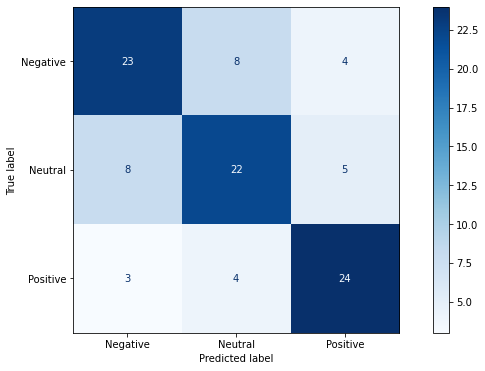

Model Performance metrics:

Accuracy: 0.7228
Precision: 0.7237
Recall: 0.7247
F1 Score: 0.7241


Model Classification report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        35
           1       0.69      0.69      0.69        35
           2       0.75      0.77      0.76        31

    accuracy                           0.72       101
   macro avg       0.72      0.72      0.72       101
weighted avg       0.72      0.72      0.72       101



Prediction Confusion Matrix:


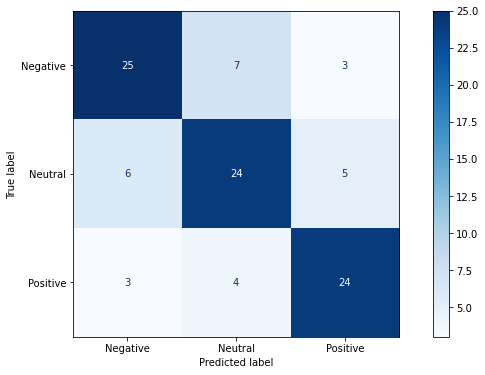

Model Performance metrics:

Accuracy: 0.7228
Precision: 0.7293
Recall: 0.7260
F1 Score: 0.7273


Model Classification report:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        35
           1       0.65      0.69      0.67        35
           2       0.83      0.81      0.82        31

    accuracy                           0.72       101
   macro avg       0.73      0.73      0.73       101
weighted avg       0.73      0.72      0.72       101



Prediction Confusion Matrix:


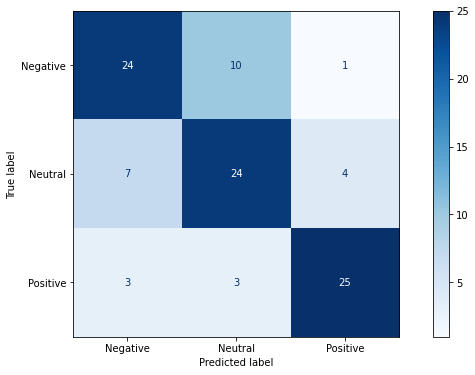

Model Performance metrics:

Accuracy: 0.7822
Precision: 0.7863
Recall: 0.7794
F1 Score: 0.7797


Model Classification report:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        35
           1       0.79      0.74      0.76        35
           2       0.81      0.71      0.76        31

    accuracy                           0.78       101
   macro avg       0.79      0.78      0.78       101
weighted avg       0.79      0.78      0.78       101



Prediction Confusion Matrix:


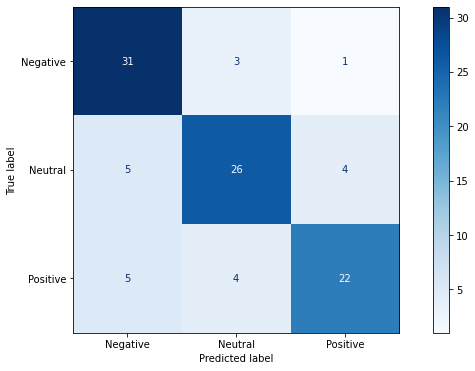

Model Performance metrics:

Accuracy: 0.8119
Precision: 0.8121
Recall: 0.8141
F1 Score: 0.8126


Model Classification report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        35
           1       0.80      0.80      0.80        35
           2       0.82      0.87      0.84        31

    accuracy                           0.81       101
   macro avg       0.81      0.81      0.81       101
weighted avg       0.81      0.81      0.81       101



Prediction Confusion Matrix:


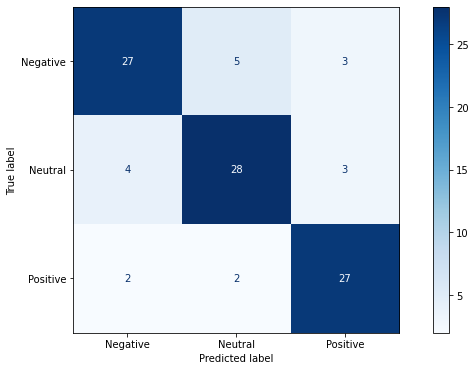

Model Performance metrics:

Accuracy: 0.7228
Precision: 0.7247
Recall: 0.7247
F1 Score: 0.7247


Model Classification report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        35
           1       0.66      0.66      0.66        35
           2       0.77      0.77      0.77        31

    accuracy                           0.72       101
   macro avg       0.72      0.72      0.72       101
weighted avg       0.72      0.72      0.72       101



Prediction Confusion Matrix:


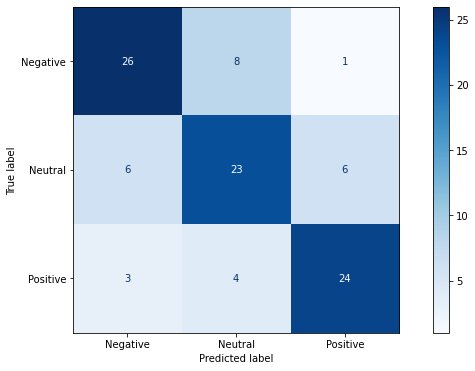

Model Performance metrics:

Accuracy: 0.7921
Precision: 0.8067
Recall: 0.7902
F1 Score: 0.7944


Model Classification report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79        35
           1       0.74      0.80      0.77        35
           2       0.92      0.74      0.82        31

    accuracy                           0.79       101
   macro avg       0.81      0.79      0.79       101
weighted avg       0.80      0.79      0.79       101



Prediction Confusion Matrix:


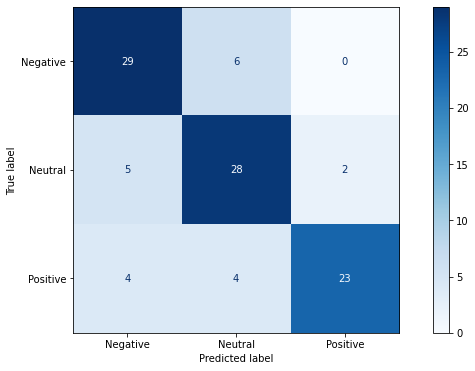

Model Performance metrics:

Accuracy: 0.7525
Precision: 0.7608
Recall: 0.7545
F1 Score: 0.7535


Model Classification report:
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        35
           1       0.76      0.63      0.69        35
           2       0.83      0.81      0.82        31

    accuracy                           0.75       101
   macro avg       0.76      0.75      0.75       101
weighted avg       0.76      0.75      0.75       101



Prediction Confusion Matrix:


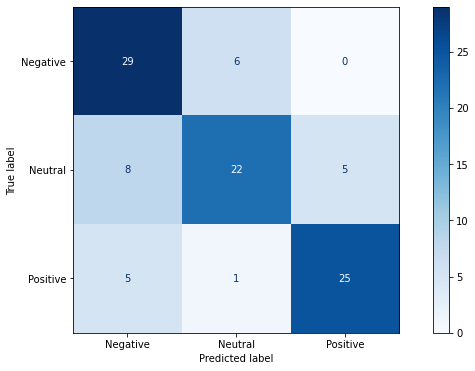

Model Performance metrics:

Accuracy: 0.7228
Precision: 0.7243
Recall: 0.7260
F1 Score: 0.7250


Model Classification report:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        35
           1       0.69      0.69      0.69        35
           2       0.78      0.81      0.79        31

    accuracy                           0.72       101
   macro avg       0.72      0.73      0.73       101
weighted avg       0.72      0.72      0.72       101



Prediction Confusion Matrix:


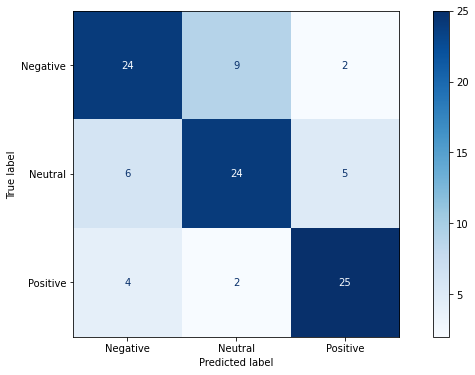

Model Performance metrics:

Accuracy: 0.7327
Precision: 0.7330
Recall: 0.7343
F1 Score: 0.7305


Model Classification report:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77        35
           1       0.72      0.60      0.66        35
           2       0.75      0.77      0.76        31

    accuracy                           0.73       101
   macro avg       0.73      0.73      0.73       101
weighted avg       0.73      0.73      0.73       101



Prediction Confusion Matrix:


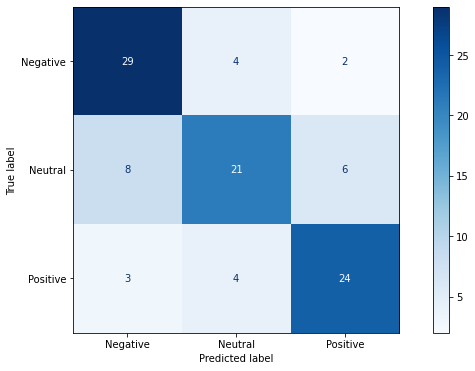

Model Performance metrics:

Accuracy: 0.7426
Precision: 0.7456
Recall: 0.7413
F1 Score: 0.7424


Model Classification report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77        35
           1       0.71      0.71      0.71        35
           2       0.79      0.71      0.75        31

    accuracy                           0.74       101
   macro avg       0.75      0.74      0.74       101
weighted avg       0.74      0.74      0.74       101



Prediction Confusion Matrix:


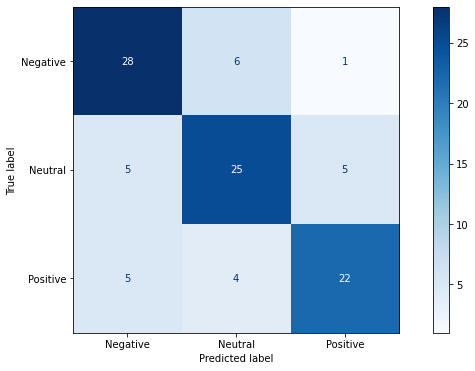

Model Performance metrics:

Accuracy: 0.7624
Precision: 0.7701
Recall: 0.7604
F1 Score: 0.7614


Model Classification report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.75        35
           1       0.71      0.86      0.78        35
           2       0.81      0.71      0.76        31

    accuracy                           0.76       101
   macro avg       0.77      0.76      0.76       101
weighted avg       0.77      0.76      0.76       101



Prediction Confusion Matrix:


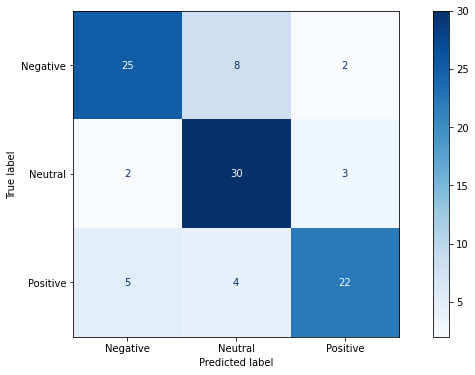

Model Performance metrics:

Accuracy: 0.7525
Precision: 0.7575
Recall: 0.7521
F1 Score: 0.7539


Model Classification report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        35
           1       0.69      0.71      0.70        35
           2       0.82      0.74      0.78        31

    accuracy                           0.75       101
   macro avg       0.76      0.75      0.75       101
weighted avg       0.76      0.75      0.75       101



Prediction Confusion Matrix:


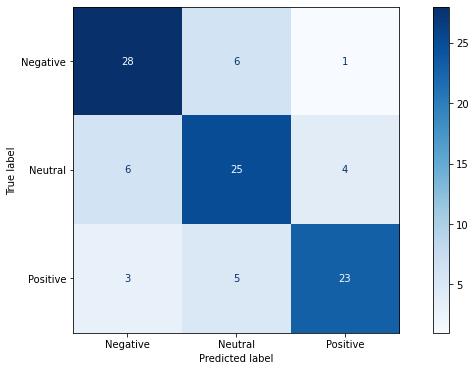

Model Performance metrics:

Accuracy: 0.7426
Precision: 0.7469
Recall: 0.7450
F1 Score: 0.7453


Model Classification report:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74        35
           1       0.70      0.66      0.68        35
           2       0.83      0.81      0.82        31

    accuracy                           0.74       101
   macro avg       0.75      0.75      0.75       101
weighted avg       0.74      0.74      0.74       101



Prediction Confusion Matrix:


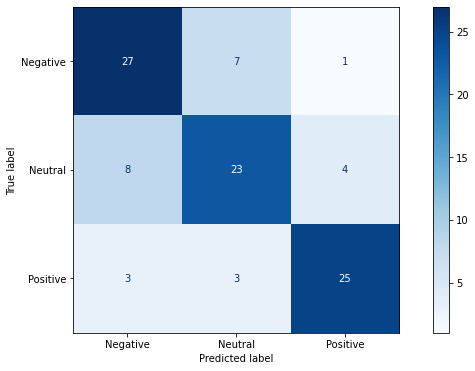

Model Performance metrics:

Accuracy: 0.7228
Precision: 0.7233
Recall: 0.7272
F1 Score: 0.7229


Model Classification report:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70        35
           1       0.71      0.69      0.70        35
           2       0.72      0.84      0.78        31

    accuracy                           0.72       101
   macro avg       0.72      0.73      0.72       101
weighted avg       0.72      0.72      0.72       101



Prediction Confusion Matrix:


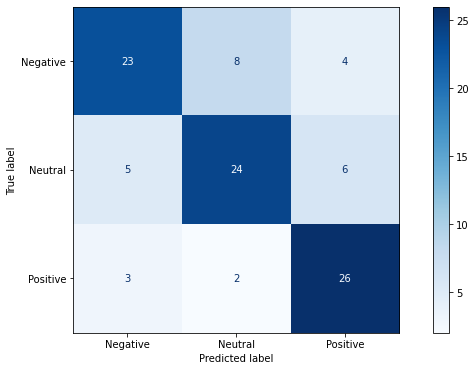

Model Performance metrics:

Accuracy: 0.7624
Precision: 0.7657
Recall: 0.7653
F1 Score: 0.7641


Model Classification report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        35
           1       0.70      0.74      0.72        35
           2       0.79      0.84      0.81        31

    accuracy                           0.76       101
   macro avg       0.77      0.77      0.76       101
weighted avg       0.76      0.76      0.76       101



Prediction Confusion Matrix:


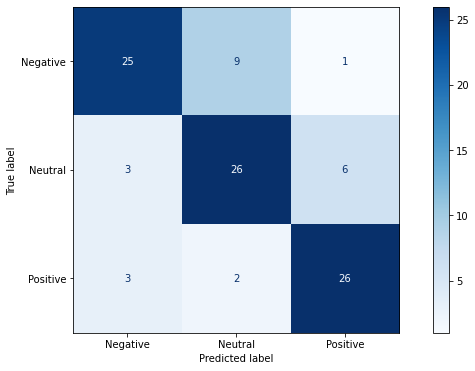

Model Performance metrics:

Accuracy: 0.7228
Precision: 0.7358
Recall: 0.7235
F1 Score: 0.7267


Model Classification report:
              precision    recall  f1-score   support

           0       0.66      0.77      0.71        35
           1       0.70      0.66      0.68        35
           2       0.85      0.74      0.79        31

    accuracy                           0.72       101
   macro avg       0.74      0.72      0.73       101
weighted avg       0.73      0.72      0.72       101



Prediction Confusion Matrix:


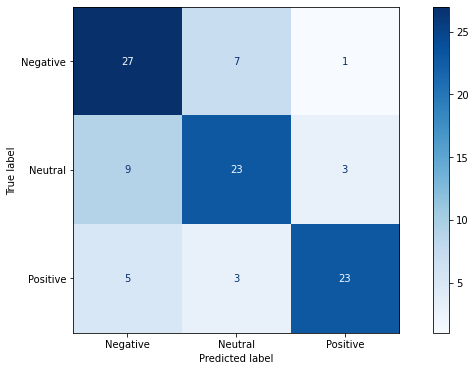

Model Performance metrics:

Accuracy: 0.7129
Precision: 0.7185
Recall: 0.7127
F1 Score: 0.7146


Model Classification report:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        35
           1       0.69      0.69      0.69        35
           2       0.79      0.71      0.75        31

    accuracy                           0.71       101
   macro avg       0.72      0.71      0.71       101
weighted avg       0.72      0.71      0.71       101



Prediction Confusion Matrix:


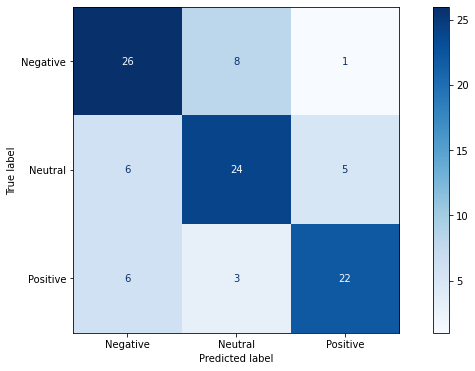

Model Performance metrics:

Accuracy: 0.7525
Precision: 0.7572
Recall: 0.7533
F1 Score: 0.7548


Model Classification report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        35
           1       0.71      0.71      0.71        35
           2       0.83      0.77      0.80        31

    accuracy                           0.75       101
   macro avg       0.76      0.75      0.75       101
weighted avg       0.75      0.75      0.75       101



Prediction Confusion Matrix:


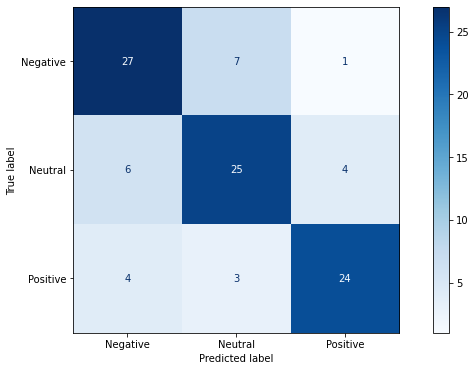

Model Performance metrics:

Accuracy: 0.7822
Precision: 0.7893
Recall: 0.7831
F1 Score: 0.7849


Model Classification report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        35
           1       0.72      0.80      0.76        35
           2       0.86      0.81      0.83        31

    accuracy                           0.78       101
   macro avg       0.79      0.78      0.78       101
weighted avg       0.79      0.78      0.78       101



Prediction Confusion Matrix:


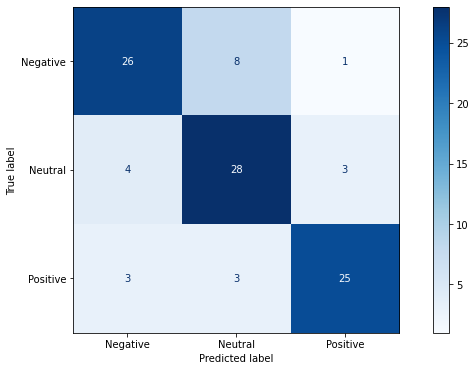

Display Ensemble test performance metrics after training 20 models
Model Performance metrics:

Accuracy: 0.7921
Precision: 0.7972
Recall: 0.7914
F1 Score: 0.7934


Model Classification report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        35
           1       0.78      0.80      0.79        35
           2       0.86      0.77      0.81        31

    accuracy                           0.79       101
   macro avg       0.80      0.79      0.79       101
weighted avg       0.79      0.79      0.79       101



Prediction Confusion Matrix:


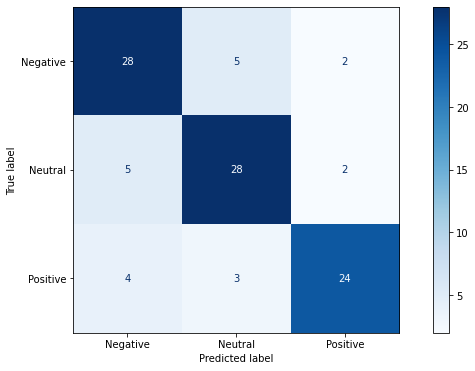

In [43]:
model_test_accuracies, ensemble_test_performance_on_number_of_models, models_mean_test_performance_on_number_of_models, models_std_test_performance_on_number_of_models = test_ensemble_models(number_of_models, tokenizer, max_len, tweets_df_test)

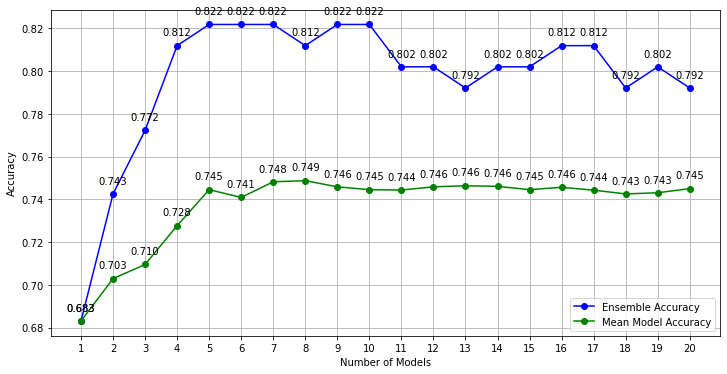

Model 1 accuracy: 68.32%
Model 2 accuracy: 72.28%
Model 3 accuracy: 72.28%
Model 4 accuracy: 78.22%
Model 5 accuracy: 81.19%
Model 6 accuracy: 72.28%
Model 7 accuracy: 79.21%
Model 8 accuracy: 75.25%
Model 9 accuracy: 72.28%
Model 10 accuracy: 73.27%
Model 11 accuracy: 74.26%
Model 12 accuracy: 76.24%
Model 13 accuracy: 75.25%
Model 14 accuracy: 74.26%
Model 15 accuracy: 72.28%
Model 16 accuracy: 76.24%
Model 17 accuracy: 72.28%
Model 18 accuracy: 71.29%
Model 19 accuracy: 75.25%
Model 20 accuracy: 78.22%

Mean models accuracy: 74.50% +- 3.02%


In [44]:
plot_ensemble_accuracy_per_number_of_models(number_of_models, ensemble_test_performance_on_number_of_models, models_mean_test_performance_on_number_of_models, models_std_test_performance_on_number_of_models)
show_model_accuracies(model_test_accuracies)